# Detecção de Anomalias em Transações Fraudulentas

# Resumo

Este notebook apresenta a primeira etapa de um projeto de detecção de fraudes em transações com cartão de crédito, com foco explícito na avaliação econômica das decisões e não apenas no desempenho estatístico dos modelos. O objetivo central é estabelecer uma base metodológica e financeira sólida para comparar políticas de decisão e modelos de machine learning ao longo do projeto.

O estudo inicia com uma análise exploratória objetiva dos dados, considerando as limitações impostas pela anonimização via PCA, e identificando padrões estruturais relevantes, como o desbalanceamento extremo da variável alvo e indícios de comportamento fraudulento coordenado ao longo do tempo. Em seguida, é realizada a quantificação do impacto econômico das fraudes, incluindo a mensuração do prejuízo observado no período analisado e uma projeção anual conservadora, de modo a traduzir eventos raros em risco financeiro mensurável.

A partir desse contexto, é construída uma métrica de negócio sensível a custo, baseada na matriz de confusão e dependente do valor das transações, que passa a ser o critério principal de avaliação do desempenho. Políticas determinísticas extremas — sempre aprovar e sempre recusar transações — são avaliadas como baselines econômicos, fornecendo referências claras e auditáveis para a comparação com modelos preditivos.

Como modelo âncora do projeto, é treinada uma regressão logística, escolhida por sua simplicidade, estabilidade e interpretabilidade. O modelo é avaliado de forma estritamente out-of-sample e demonstra capacidade de gerar ganho econômico adicional em relação ao baseline. Na sequência, o limiar de decisão é tratado como parte da política operacional, sendo otimizado com base na métrica de negócio exclusivamente no conjunto de validação e posteriormente aplicado ao conjunto de teste.

Por fim, o notebook avalia a capacidade do modelo em mitigar o impacto financeiro das fraudes, bem como sua estabilidade estatística e resiliência econômica sob cenários adversos, incluindo stress tests de deterioração do ambiente e introdução de ruído nos dados. Os resultados obtidos posicionam a regressão logística como referência econômica mínima para as etapas seguintes do projeto, nas quais modelos mais complexos serão avaliados com base em ganhos econômicos incrementais.

Mitigação do impacto financeiro das fraudes

- Impacto financeiro bruto das fraudes no período analisado: €9.874,35

- Prejuízo residual (fraudes não detectadas): €2.563,08

- Valor financeiro das fraudes evitadas: €7.311,27

- Percentual de mitigação do impacto das fraudes: ≈ 74,6%

Esses resultados indicam que o modelo foi capaz de bloquear aproximadamente três quartos do prejuízo potencial causado por fraudes, mesmo sendo um modelo supervisionado simples.

Ganho econômico líquido

- Baseline econômico (sempre aprovar transações): €90.280,45

- Modelo com threshold padrão: €100.198,80

- Modelo com threshold otimizado: €101.457,27

Comparativamente:

- Ganho absoluto vs. baseline: €11.176,82

- Ganho percentual vs. baseline: ≈ 12,4%

Esse aumento de valor foi obtido sem aumento da complexidade do modelo, sendo resultado direto da adoção de uma política de decisão orientada a custo.

# Introdução

A detecção de fraudes em transações com cartão de crédito é um dos problemas clássicos e mais relevantes em ciência de dados aplicada, especialmente por envolver eventos raros, alto impacto financeiro e decisões operacionais em tempo real. Pequenos erros de classificação podem gerar perdas financeiras significativas ou, no sentido oposto, impactar negativamente a experiência do cliente por meio de recusas indevidas.

Neste projeto, será desenvolvido um sistema de detecção de fraudes utilizando dados reais de transações de cartões de crédito, com foco não apenas em métricas estatísticas tradicionais, mas principalmente na mensuração do valor econômico gerado pelas decisões do modelo. A proposta central é alinhar o desempenho do modelo aos objetivos de negócio por meio de uma abordagem de aprendizado sensível a custos, incorporando o valor monetário de cada transação ao processo de avaliação e decisão.

Além disso, o projeto explora e compara diferentes paradigmas de modelagem — modelos supervisionados e não supervisionados — culminando na avaliação de estratégias híbridas, como blending, para maximizar o benefício econômico total.

Referências:
- Dataset Kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud

# Importando as Bibliotecas

In [1]:
# Manipulação de Dados
import numpy as np
import pandas as pd
import json


# Visualização
import matplotlib.pyplot as plt
import seaborn as sns


# Modelagem, Validação e Pipelines
import sklearn
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    learning_curve
)
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression


# Pré-processamento
from sklearn.preprocessing import (
    StandardScaler,
)
from sklearn.compose import ColumnTransformer


# Métricas e Avaliação
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    make_scorer,
    auc,
    precision_recall_curve,
)


# Calibração
from sklearn.calibration import (
    calibration_curve
)


# Salvamento de Modelos
import joblib


# Balanceamento de Classes
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek


# Funções Auxiliares
import utils.aux_func as af
from utils.paths import (
    DATA_RAW,
    SPLITS_DIR, 
    ANCHOR_ARTIFACTS_DIR,
    METRIC_ARTIFACTS_DIR
)

# Configurações Gerais
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.dpi"] = 400
pd.set_option("display.max_columns", None)


# Importando a Base

In [2]:
df = pd.read_csv(DATA_RAW / 'creditcard.csv')
df.head(5)

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19       V20       V21  \
0  1.468177 -0.470401  0.207971  0.025791  0.403993  0.251412 -0.018307   
1  0.635558  0.463917 -0.114805 -0.183361 -0.145783 -0.069083 -0.225775   
2  2.345865 -2.890083  1.109969 -0.121359 -2.261857  0.524980  0.247998   
3 -0.631418 -1.059647 -0.684093  1.965775 -1.232622 -0.208038 -0.108300   
4  0.175121 -0.451449 -0.237033 -0.038195  0.803487  0.408542 -0.009431   

        V22       V23       V24       V25       V26       V27       V28  \
0  0.277838 -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053   
1 -0.638672  0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724   
2  0.771679  0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752   
3  0.005274 -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458   
4  0.798278 -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153   

   Amount  Class  
0  149.62      0  
1    2.69      0  
2  378.66      0  
3  123.50      0  
4   69.99      0

In [3]:
df.shape

(284807, 31)

# EDA Básica

## Estrutura e Natureza dos Dados

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Devido a restrições de confidencialidade, a maior parte das variáveis do dataset passou por uma transformação de **Análise de Componentes Principais (PCA)**. As colunas disponíveis são:

- Vetores (V1, V2, …, V28): componentes principais obtidas via PCA;

- Time: tempo decorrido (em segundos) desde a primeira transação do dataset;

- Amount: valor monetário da transação;

- Class: variável alvo, onde 1 indica fraude e 0 indica transação legítima.

Apesar da limitação interpretativa das variáveis transformadas, o dataset é extremamente rico do ponto de vista metodológico, especialmente por conter a variável `Amount`, que permite a formulação de funções de custo dependentes do valor da transação.

## Balanceamento da Variável Target

In [5]:
df["Class"].value_counts(normalize=True).mul(100)

Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64

In [6]:
df["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

Observamos que o dataset contém **284.807 transações**, das quais apenas **492 são classificadas como fraude**, representando 0,17% do total. Esse cenário caracteriza um desbalanceamento extremo da variável target, típico de problemas reais de detecção de fraude. Esse nível de desbalanceamento traz implicações nas métricas tradicionais de desempenho, como a acurácia, que se tornam pouco informativas, pois um modelo trivial que classifique todas as transações como legítimas acertaria 99% das transações. Sendo assim, há um risco elevado de viés em favor da classe majoritária. Torna-se essencial o uso de métricas apropriadas ao contexto, como Recall, Precision, F1-Score, AUC-ROC, KS e métricas orientadas a custo.

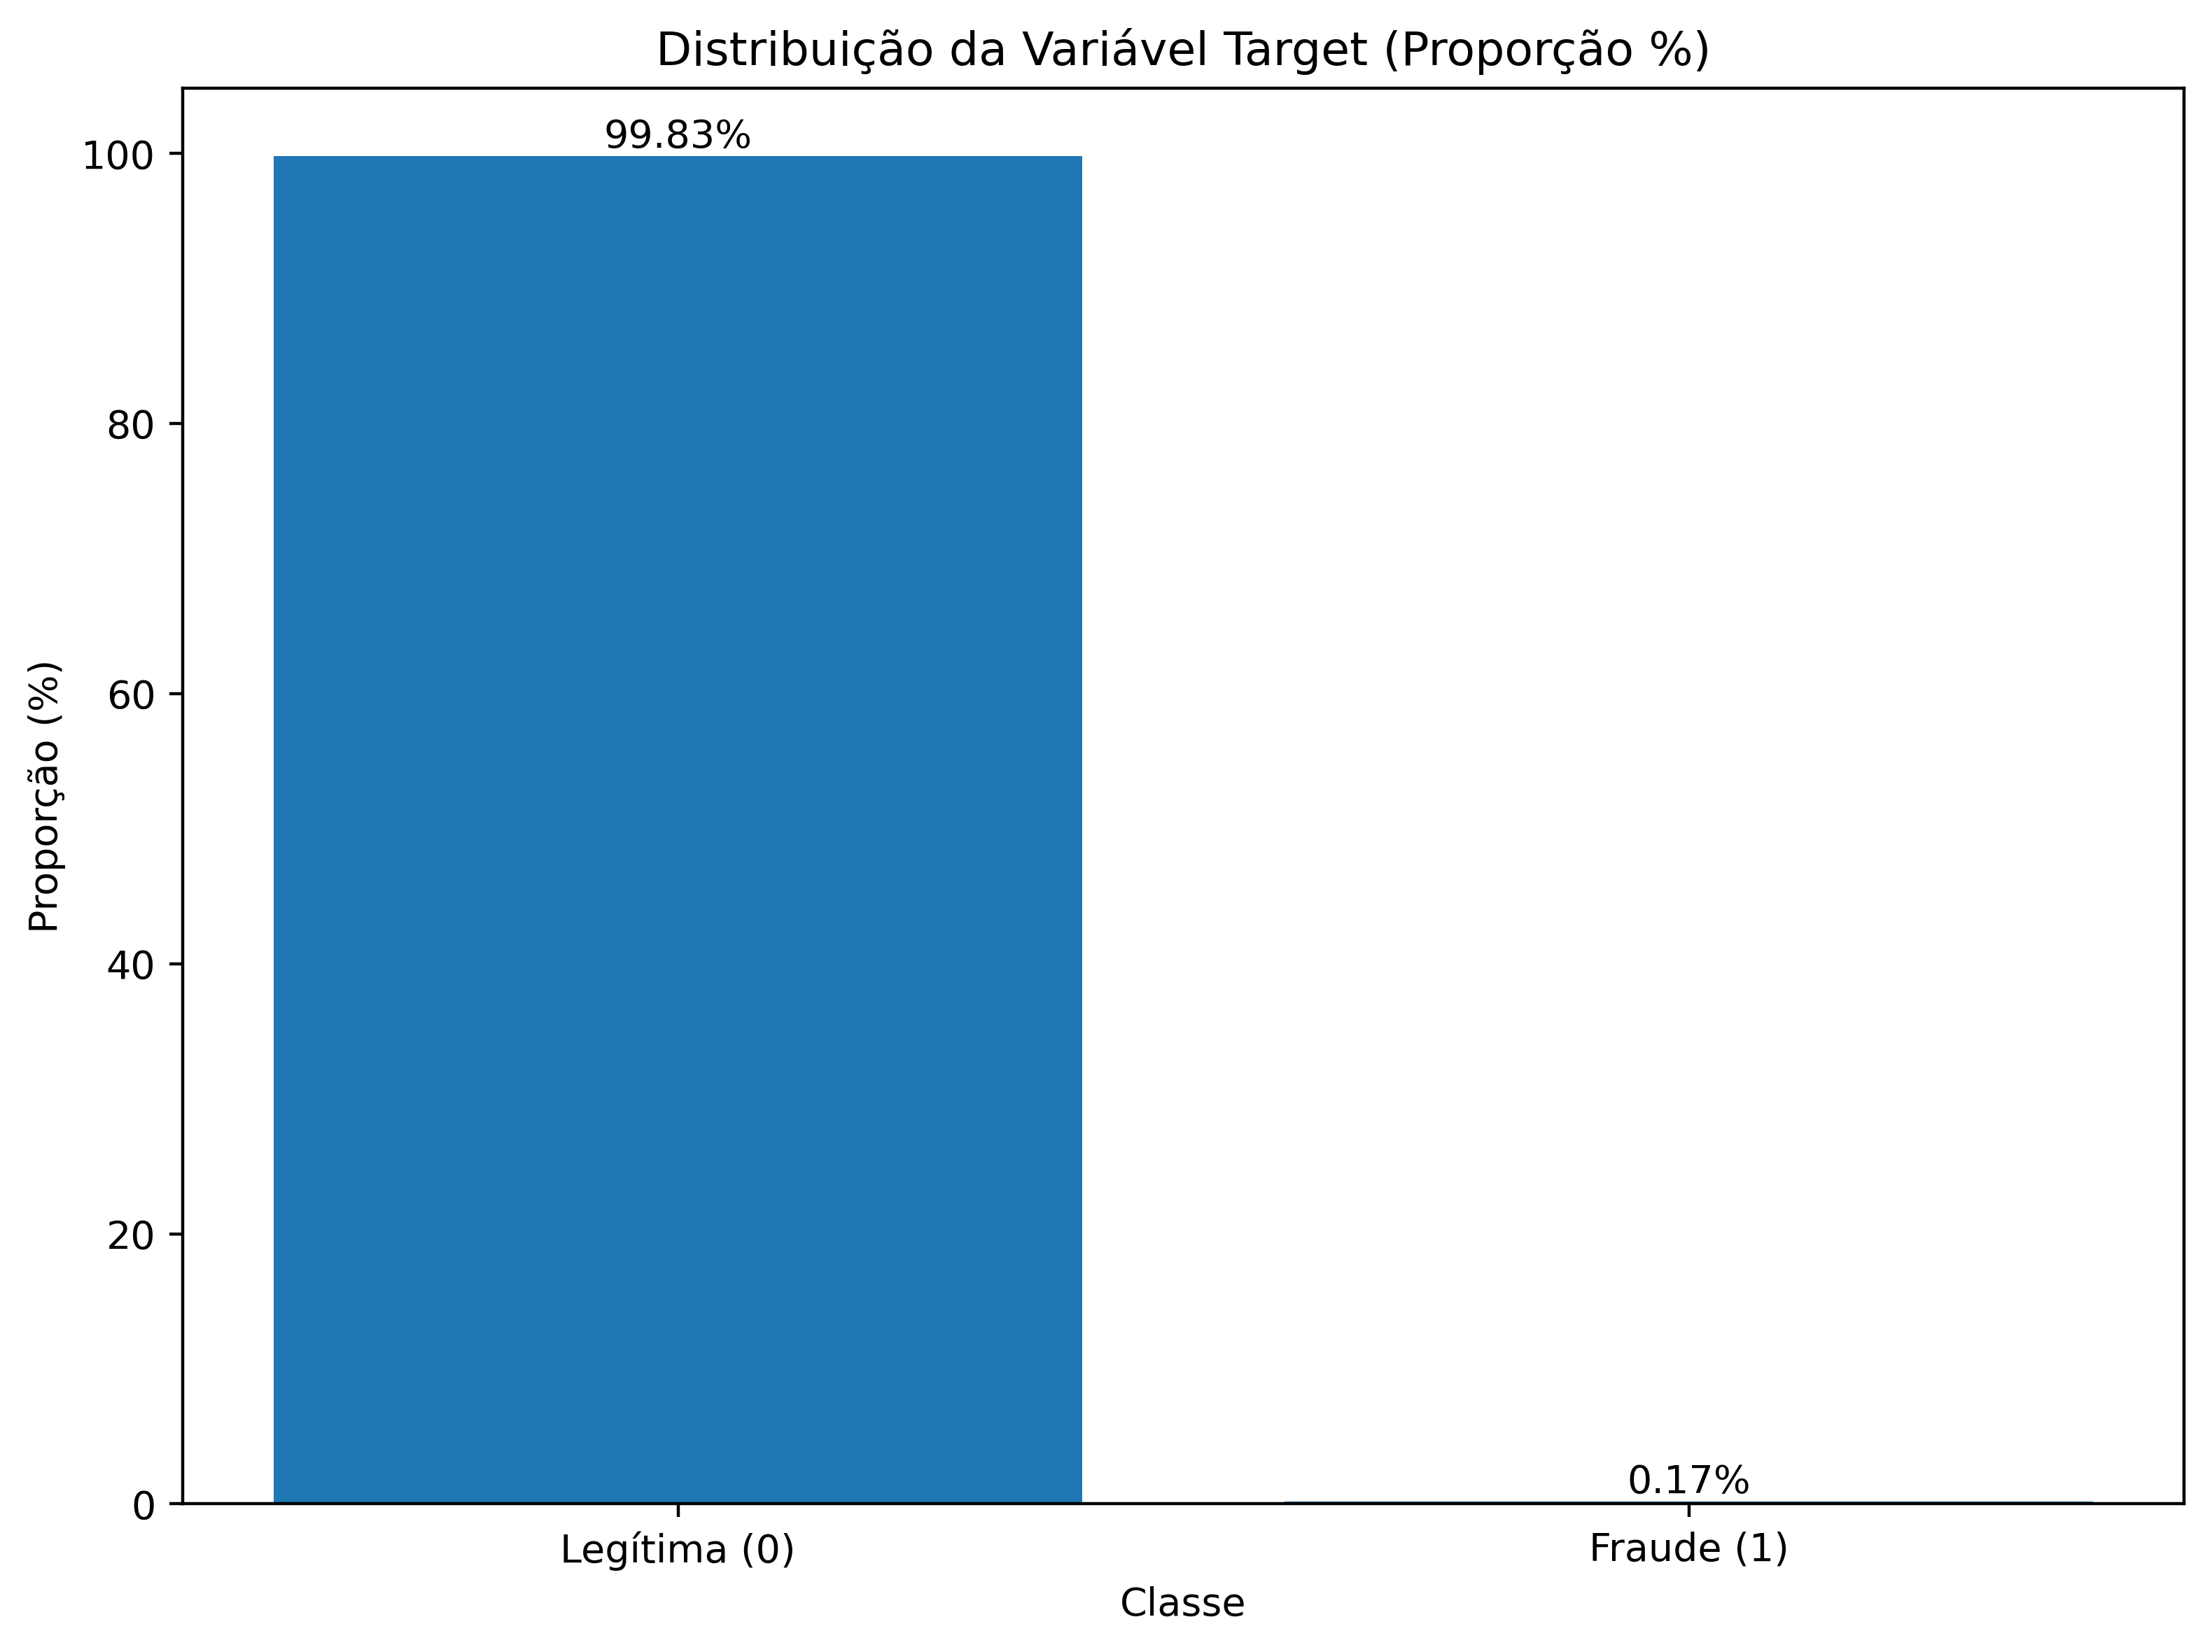

In [7]:
# Proporção da variável target
target_prop = df['Class'].value_counts(normalize=True).sort_index() * 100

plt.figure(figsize=(8, 6))
plt.bar(target_prop.index.astype(str), target_prop.values)
plt.title("Distribuição da Variável Target (Proporção %)")
plt.xlabel("Classe")
plt.ylabel("Proporção (%)")
plt.xticks(["0", "1"], ["Legítima (0)", "Fraude (1)"])

# Adicionando rótulos percentuais
for i, v in enumerate(target_prop.values):
    plt.text(i, v, f"{v:.2f}%", ha="center", va="bottom")

plt.tight_layout()
plt.show()



## Matriz de Correlação

In [8]:
# Selecionando apenas as variáveis de interesse
corr_matrix = df[['Time', 'Amount']].corr(method='pearson')

corr_matrix

Time    Amount
Time    1.000000 -0.010596
Amount -0.010596  1.000000

A matriz de correlação entre `Time` e `Amount` indica ausência de relação linear significativa entre essas variáveis. Esse resultado é consistente com a natureza do problema e sugere que ambas fornecem informações complementares ao modelo, não havendo evidência de redundância entre elas.

## Distribuição das Transações Fraudulentas

In [9]:
# Filtrando apenas transações fraudulentas
df_fraude = df[df['Class'] == 1]

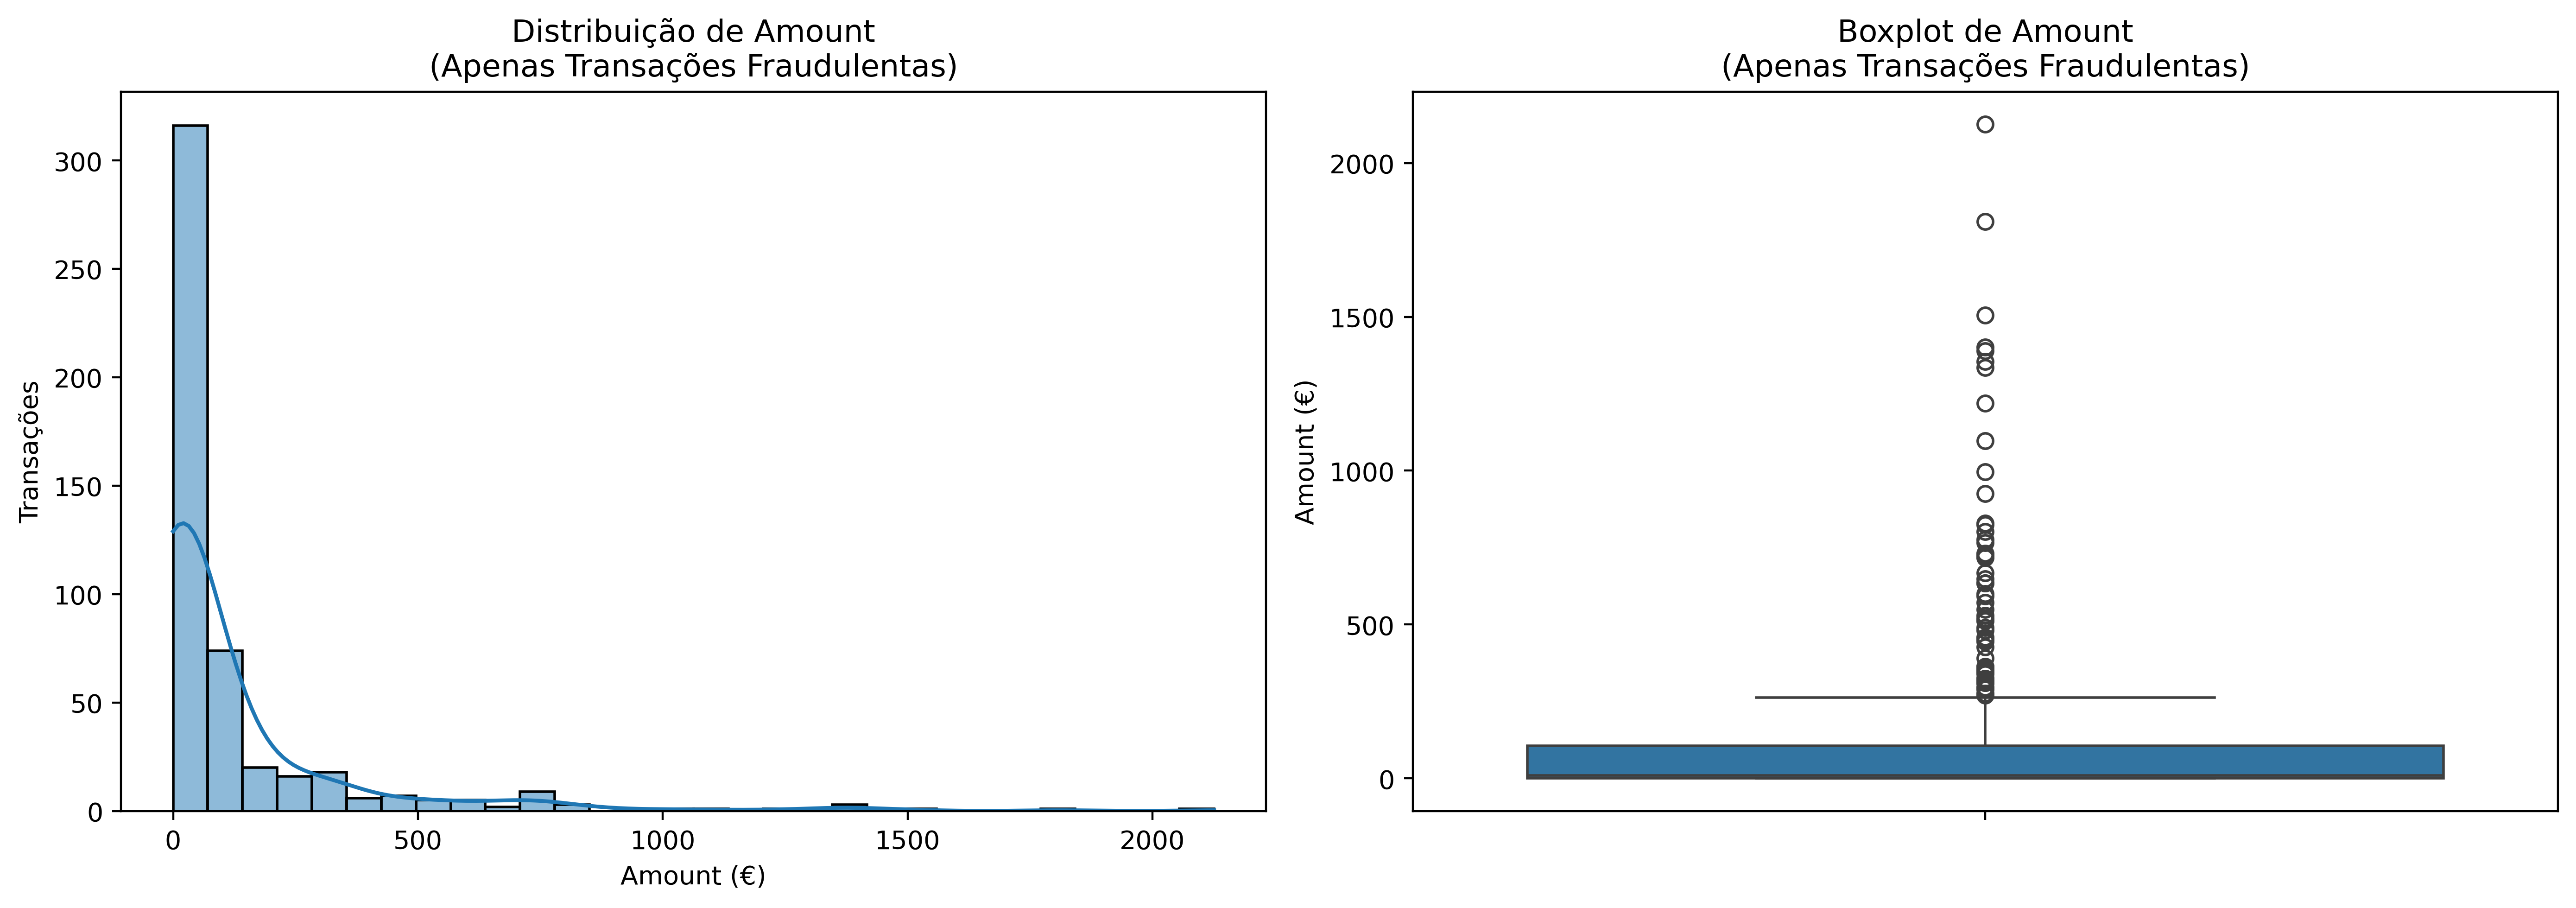

In [10]:
# Criando os subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1) Distribuição (Histograma + KDE)
sns.histplot(
    df_fraude['Amount'],
    bins=30,
    kde=True,
    ax=axes[0]
)

axes[0].set_title("Distribuição de Amount\n(Apenas Transações Fraudulentas)")
axes[0].set_xlabel("Amount (€)")
axes[0].set_ylabel("Transações")

# 2) Boxplot
sns.boxplot(
    y=df_fraude['Amount'],
    ax=axes[1]
)

axes[1].set_title("Boxplot de Amount\n(Apenas Transações Fraudulentas)")
axes[1].set_ylabel("Amount (€)")

plt.tight_layout()
plt.show()

As transações fraudulentas apresentam forte assimetria na variável `Amount`, com elevada concentração em valores muito baixos, característica compatível com testes automatizados e validações de cartão. Observam-se, entretanto, poucos eventos de alto valor, que embora raros, possuem impacto econômico relevante. Esse padrão sugere a coexistência de diferentes regimes de fraude, desde ataques exploratórios até eventos de maior prejuízo financeiro.

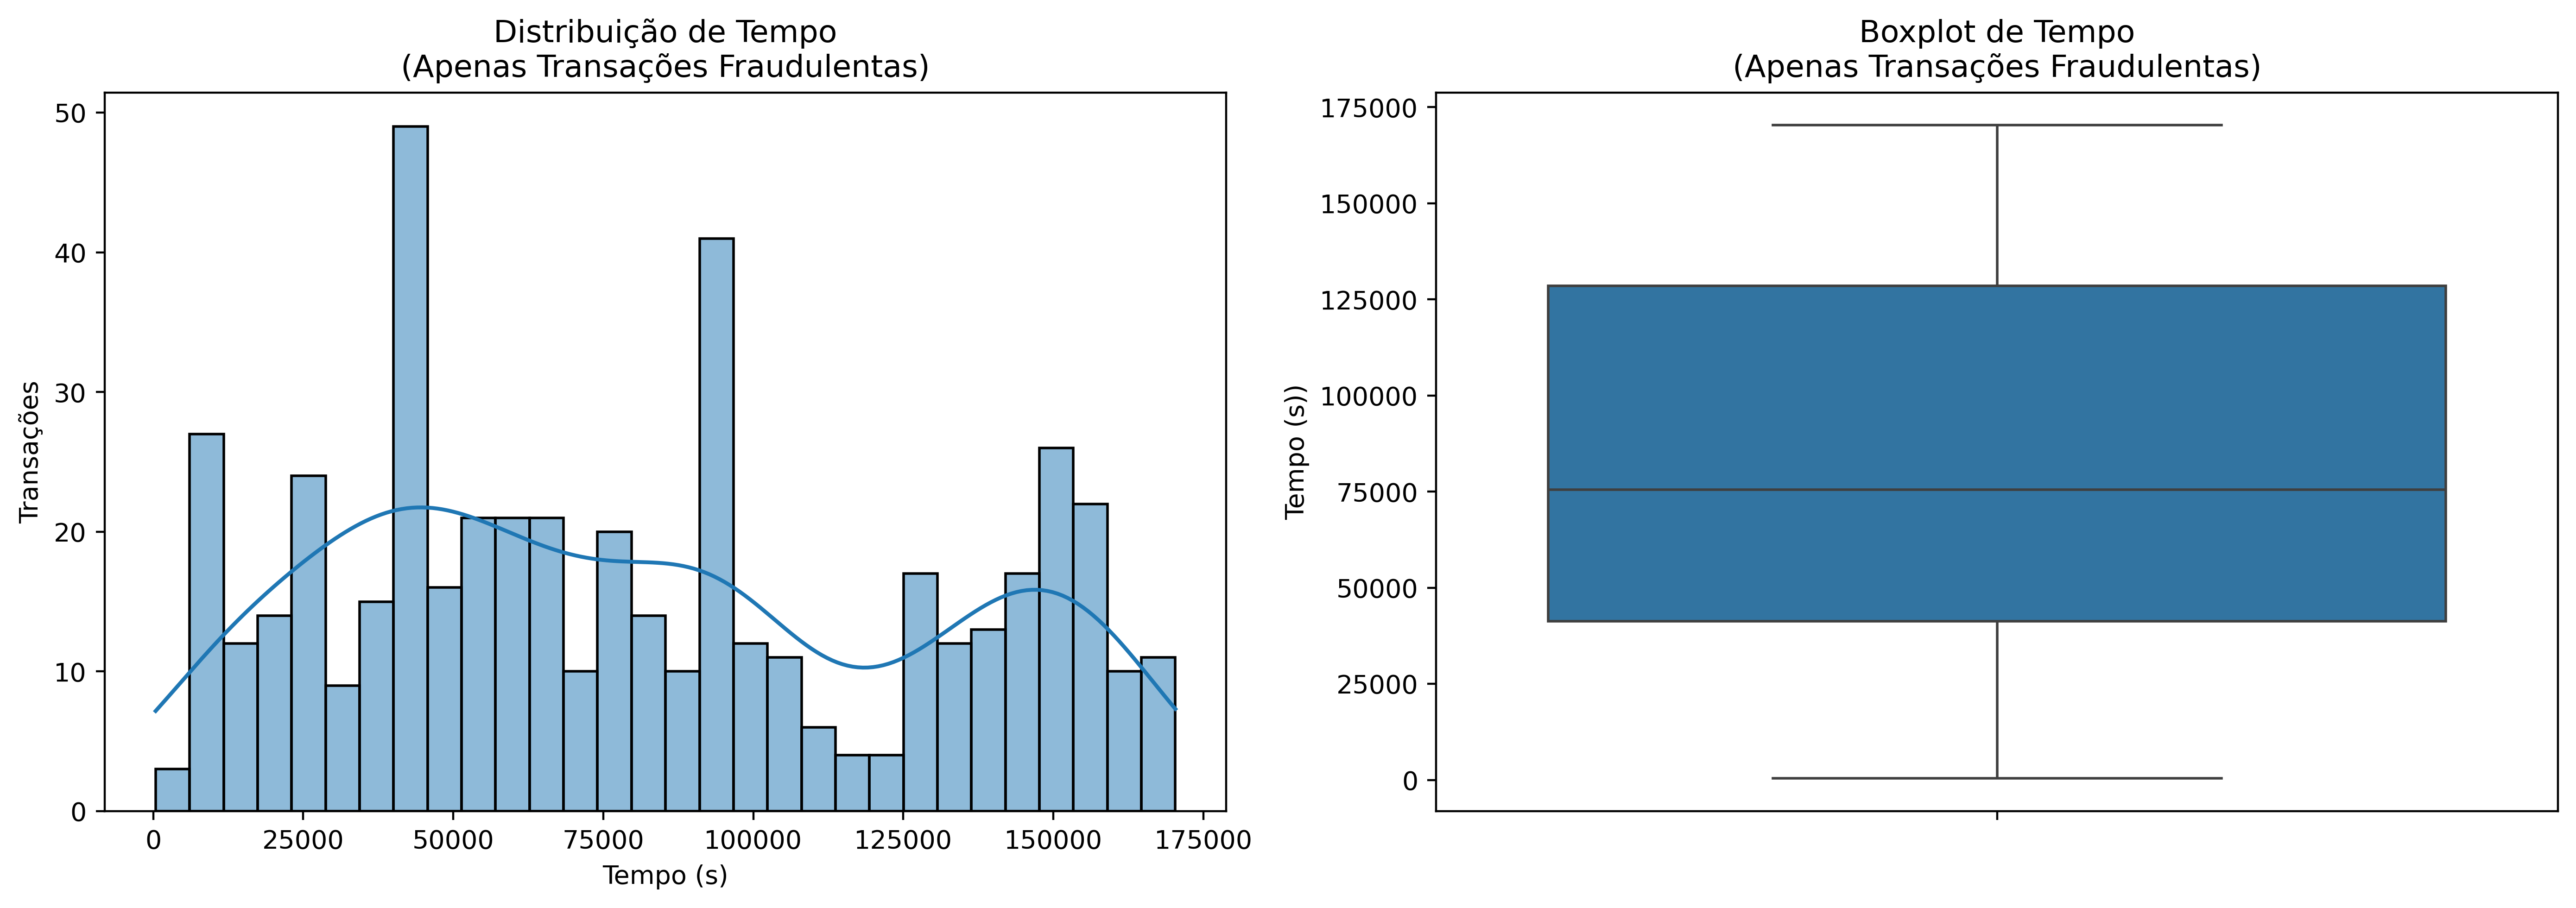

In [11]:
# Criando os subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1) Distribuição (Histograma + KDE)
sns.histplot(
    df_fraude['Time'],
    bins=30,
    kde=True,
    ax=axes[0]
)

axes[0].set_title("Distribuição de Tempo\n(Apenas Transações Fraudulentas)")
axes[0].set_xlabel("Tempo (s)")
axes[0].set_ylabel("Transações")

# 2) Boxplot
sns.boxplot(
    y=df_fraude['Time'],
    ax=axes[1]
)

axes[1].set_title("Boxplot de Tempo\n(Apenas Transações Fraudulentas)")
axes[1].set_ylabel("Tempo (s))")

plt.tight_layout()
plt.show()

Em relação à variável `Time`, a distribuição das transações fraudulentas não indica uma tendência temporal global clara, apresentando ampla dispersão ao longo do período analisado. Ainda assim, a presença de picos locais de densidade sugere janelas temporais com maior incidência de fraudes, o que é consistente com a hipótese de ataques coordenados ou pré-programados.

In [12]:
df_fraude["Amount"].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [13]:
(df_fraude["Amount"] == 0).sum()

np.int64(27)

In [14]:
df[df['Amount'] == 0]['Class'].value_counts()

Class
0    1798
1      27
Name: count, dtype: int64

Foram identificadas 1.825 transações com valor monetário igual a zero, o que representa uma fração marginal frente ao volume total da base (superior a 200 mil transações). Dentre essas observações, 27 transações (≈1,5%) foram rotuladas como fraudulentas.

Apesar de a taxa de fraude observada nesse subconjunto ser superior à média global, a baixa representatividade absoluta dessas ocorrências limita seu impacto potencial no desempenho agregado do modelo. Além disso, a presença majoritária de transações não fraudulentas nesse grupo não configura inconsistência, uma vez que operações de valor zero são comuns em validações legítimas de cartão, testes de autorização e verificações automatizadas que não evoluem para uma tentativa efetiva de fraude.

Em bases reais de detecção de fraude, é também esperado algum nível de ruído de rótulo, de modo que comportamentos suspeitos nem sempre resultam em eventos classificados como fraude. Dessa forma, a condição Amount = 0 foi interpretada como um possível sinal comportamental fraco, cuja relevância preditiva não poderia ser inferida apenas pela análise exploratória.

Diante disso, optou-se por avaliar formalmente esse achado por meio de engenharia de atributos, criando uma variável indicadora (`flag_amount_zero`) e mensurando seu impacto incremental em relação a um modelo âncora, utilizando métricas de classificação e, principalmente, uma métrica de negócio, sob uma política de decisão previamente otimizada.

## Conclusão da EDA

Os padrões observados em `Amount` e `Time` reforçam que a detecção de fraude é um problema intrinsecamente probabilístico e assimétrico, no qual eventos raros de alto impacto coexistem com comportamentos frequentes de baixo valor. Esse cenário justifica, nas etapas seguintes, a adoção de métricas sensíveis ao desbalanceamento, análise de custo e otimização de limiar de decisão.

# Definindo a Métrica de Negócio

Em problemas de detecção de fraudes em transações financeiras, métricas estatísticas tradicionais — como acurácia, F1-score ou AUC-ROC — são insuficientes para avaliar o impacto real das decisões do modelo. Isso ocorre porque diferentes erros de classificação geram custos econômicos assimétricos e, no caso específico deste problema, tais custos dependem do valor individual de cada transação.

Dessa forma, a avaliação do modelo não deve se limitar à sua capacidade de discriminação estatística, mas sim à sua habilidade de maximizar o benefício econômico total resultante das decisões de aceitar ou recusar transações. Com esse objetivo, adotamos uma métrica de negócio inspirada em literatura especializada e em um exemplo oficial do scikit-learn, que modela explicitamente os ganhos e perdas associados a cada possível decisão.

## Impacto Econômico das Fraudes

In [15]:
# Período de tempo que as transações foram observadas em dias
df['Time'].max()/(3600*24)

1.9999074074074075

In [16]:
# quantidade total do valor das transações fraudulentas em Euros
total_fraud_amount = df_fraude["Amount"].sum()
total_fraud_amount

np.float64(60127.97)

In [17]:
total_fraud_amount_month = df_fraude["Amount"].sum() * 15
total_fraud_amount_month

np.float64(901919.55)

In [18]:
total_fraud_amount_year = total_fraud_amount_month * 12
total_fraud_amount_year.round(2)

np.float64(10823034.6)

## Lógica Econômica por trás da métrica

O problema é formulado como uma decisão binária: aceitar ou recusar uma transação. Considerando que a classe positiva (`Class = 1`) representa fraudes e a classe negativa (`Class = 0`) representa transações legítimas, cada combinação entre decisão do modelo e estado real da transação gera um impacto econômico distinto:

- Fraude recusada (True Positive)


    Representa a identificação correta de uma fraude. A recusa evita custos operacionais futuros, como chargebacks e investigações, sendo modelada como um ganho fixo de €50 por transação.

- Fraude aceita (False Negative)


    Corresponde à falha em detectar uma fraude. Nesse caso, a empresa incorre em uma perda equivalente ao valor total da transação, pois o prejuízo é diretamente proporcional ao montante fraudado.

- Transação legítima recusada (False Positive)


    Representa um erro operacional que afeta a experiência do cliente. Esse impacto é modelado como uma perda fixa de €5, refletindo custos de fricção, atendimento ou potencial churn.

- Transação legítima aceita (True Negative)

    Corresponde a uma decisão correta que gera valor econômico. Esse benefício é modelado como um ganho proporcional ao valor da transação, estimado em 2% do Amount, representando uma aproximação de taxas operacionais ou margem de intermediação.

In [19]:
def business_metric(
    y_true,
    y_pred,
    amount,
    gain_legitimate_accept_rate=0.02,   # ganho sobre transação legítima aceita
    gain_fraud_refuse=50,               # ganho fixo por fraude corretamente recusada
    loss_legitimate_refuse=5            # perda fixa por transação legítima recusada
):
    """
    Calcula o benefício econômico total de uma política de decisão
    para detecção de fraudes em transações financeiras.

    Parâmetros
    ----------
    y_true : array-like
        Rótulos reais (1 = fraude, 0 = legítima)
    y_pred : array-like
        Decisões do modelo (1 = recusar, 0 = aceitar)
    amount : array-like
        Valor monetário de cada transação

    Retorno
    -------
    float
        Benefício econômico total
    """

    # Máscaras de Decisão
    tp = (y_true == 1) & (y_pred == 1)
    fn = (y_true == 1) & (y_pred == 0)
    fp = (y_true == 0) & (y_pred == 1)
    tn = (y_true == 0) & (y_pred == 0)

    # Componentes econômicos
    benefit_fraud_refuse = tp.sum() * gain_fraud_refuse
    loss_fraud_accept = -amount[fn].sum()
    loss_legitimate_refuse_cost = -fp.sum() * loss_legitimate_refuse
    benefit_legitimate_accept = (amount[tn] * gain_legitimate_accept_rate).sum()

    return (
        benefit_fraud_refuse
        + loss_fraud_accept
        + loss_legitimate_refuse_cost
        + benefit_legitimate_accept
    )


É importante observar que `Amount` assume dois papéis distintos neste projeto. O primeiro papel é como **feature do modelo** que é utilizada durante o treinamento do modelo para ajudar o classificador a estimar a probabilidade de uma transação ser fraudulenta, dado que o valor da transação é uma informação disponível no momento da decisão. Já o segundo, é como **parâmetro da métrica de negócio**, onde ela é utilizada exclusivamente para calcular o impacto econômico das decisões tomadas pelo modelo.

Esses dois usos são conceitualmente diferentes e **não devem ser misturados**. Para preservar essa separação, o `Amount` é tratado como **metadado** durante a avaliação do modelo. Isso significa que ele não influencia as previsões geradas pelo classificador, mas é encaminhado separadamente para a função de avaliação, onde é utilizado apenas para ponderar ganhos e perdas.

Podemos ver um exemplo mais detalhado no artigo: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cost_sensitive_learning.html#consideration-regarding-model-refitting-and-cross-validation

In [20]:
sklearn.set_config(enable_metadata_routing=True)
business_scorer = make_scorer(business_metric).set_score_request(amount=True)

# Pré-Processamento Básico

## Separando X e y

In [21]:
# features vars
X = df.drop(columns=["Class", "Time"])

# target
y = df["Class"]

# metadado
amount = df["Amount"].to_numpy()

In [22]:
X

V1         V2        V3        V4        V5        V6  \
0       -1.359807  -0.072781  2.536347  1.378155 -0.338321  0.462388   
1        1.191857   0.266151  0.166480  0.448154  0.060018 -0.082361   
2       -1.358354  -1.340163  1.773209  0.379780 -0.503198  1.800499   
3       -0.966272  -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4       -1.158233   0.877737  1.548718  0.403034 -0.407193  0.095921   
...           ...        ...       ...       ...       ...       ...   
284802 -11.881118  10.071785 -9.834783 -2.066656 -5.364473 -2.606837   
284803  -0.732789  -0.055080  2.035030 -0.738589  0.868229  1.058415   
284804   1.919565  -0.301254 -3.249640 -0.557828  2.630515  3.031260   
284805  -0.240440   0.530483  0.702510  0.689799 -0.377961  0.623708   
284806  -0.533413  -0.189733  0.703337 -0.506271 -0.012546 -0.649617   

              V7        V8        V9       V10       V11       V12       V13  \
0       0.239599  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390   
1      -0.078803  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095   
2       0.791461  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293   
3       0.237609  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757   
4       0.592941 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852   
...          ...       ...       ...       ...       ...       ...       ...   
284802 -4.918215  7.305334  1.914428  4.356170 -1.593105  2.711941 -0.689256   
284803  0.024330  0.294869  0.584800 -0.975926 -0.150189  0.915802  1.214756   
284804 -0.296827  0.708417  0.432454 -0.484782  0.411614  0.063119 -0.183699   
284805 -0.686180  0.679145  0.392087 -0.399126 -1.933849 -0.962886 -1.042082   
284806  1.577006 -0.414650  0.486180 -0.915427 -1.040458 -0.031513 -0.188093   

             V14       V15       V16       V17       V18       V19       V20  \
0      -0.311169  1.468177 -0.470401  0.207971  0.025791  0.403993  0.251412   
1      -0.143772  0.635558  0.463917 -0.114805 -0.183361 -0.145783 -0.069083   
2      -0.165946  2.345865 -2.890083  1.109969 -0.121359 -2.261857  0.524980   
3      -0.287924 -0.631418 -1.059647 -0.684093  1.965775 -1.232622 -0.208038   
4      -1.119670  0.175121 -0.451449 -0.237033 -0.038195  0.803487  0.408542   
...          ...       ...       ...       ...       ...       ...       ...   
284802  4.626942 -0.924459  1.107641  1.991691  0.510632 -0.682920  1.475829   
284803 -0.675143  1.164931 -0.711757 -0.025693 -1.221179 -1.545556  0.059616   
284804 -0.510602  1.329284  0.140716  0.313502  0.395652 -0.577252  0.001396   
284805  0.449624  1.962563 -0.608577  0.509928  1.113981  2.897849  0.127434   
284806 -0.084316  0.041333 -0.302620 -0.660377  0.167430 -0.256117  0.382948   

             V21       V22       V23       V24       V25       V26       V27  \
0      -0.018307  0.277838 -0.110474  0.066928  0.128539 -0.189115  0.133558   
1      -0.225775 -0.638672  0.101288 -0.339846  0.167170  0.125895 -0.008983   
2       0.247998  0.771679  0.909412 -0.689281 -0.327642 -0.139097 -0.055353   
3      -0.108300  0.005274 -0.190321 -1.175575  0.647376 -0.221929  0.062723   
4      -0.009431  0.798278 -0.137458  0.141267 -0.206010  0.502292  0.219422   
...          ...       ...       ...       ...       ...       ...       ...   
284802  0.213454  0.111864  1.014480 -0.509348  1.436807  0.250034  0.943651   
284803  0.214205  0.924384  0.012463 -1.016226 -0.606624 -0.395255  0.068472   
284804  0.232045  0.578229 -0.037501  0.640134  0.265745 -0.087371  0.004455   
284805  0.265245  0.800049 -0.163298  0.123205 -0.569159  0.546668  0.108821   
284806  0.261057  0.643078  0.376777  0.008797 -0.473649 -0.818267 -0.002415   

             V28  Amount  
0      -0.021053  149.62  
1       0.014724    2.69  
2      -0.059752  378.66  
3       0.061458  123.50  
4       0.215153   69.99  
...          ...     ...  
284802  0.823731    0.77  
284803 -0.053527   24.79  
284804 -0.026561   67.88

In [23]:
y

0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 284807, dtype: int64

## Separando a Base em Treino, Validação e Teste

In [24]:
# definindo fraçoes de particionamento
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

X_train, X_temp, y_train, y_temp, amount_train, amount_temp = train_test_split(
    X,
    y,
    amount,
    test_size=(1 - train_ratio),
    stratify=y,
    random_state=42
)

In [25]:
val_size_normalized = val_ratio / (val_ratio + test_ratio)

X_val, X_test, y_val, y_test, amount_val, amount_test = train_test_split(
    X_temp,
    y_temp,
    amount_temp,
    test_size=val_size_normalized,
    stratify=y_temp,
    random_state=42
)

In [26]:
(X_train.shape, y_train.shape, amount_train.shape)

((170884, 29), (170884,), (170884,))

In [27]:
(X_val.shape,   y_val.shape,   amount_val.shape)

((56961, 29), (56961,), (56961,))

In [28]:
(X_test.shape,  y_test.shape,  amount_test.shape)

((56962, 29), (56962,), (56962,))

# Definindo o Baseline Econômico

Nesta fase inicial, avaliamos políticas de decisão puramente determinísticas, que não utilizam aprendizado a partir dos dados históricos. O objetivo não é otimizar decisões, mas sim quantificar o impacto financeiro de estratégias extremas e facilmente auditáveis, que representam cenários operacionais limites.

Para isso, vamos consideradar duas políticas básicas, implementadas por meio do `DummyClassifier` do scikit-learn, para quantificar o impacto econômico do problema sem qualquer forma de modelagem. Além de estabelecer limites inferiores e superiores para o desempenho financeiro de políticas de decisão, gerando assim um referencial claro e auditável contra o qual os modelos de machine learning serão comparados.

## Sempre Aprovar as Transações (Always Accept)

Essa política representa um cenário em que nenhuma transação é recusada, independentemente de seu risco. Na prática, ela equivale à ausência completa de um sistema antifraude. Ela acceita todas as transações legítimas e fraudulentas, gerando perdas financeiras proporcionais ao valor das fraudes. Além disso, não há custos associados à recusa indevida de clientes legítimos nem ganhos provenientes de detecção de fraudes.

In [29]:
always_accept_policy = DummyClassifier(strategy="constant", constant=0)
always_accept_policy.fit(X_train, y_train)

benefit_accept = business_scorer(
    always_accept_policy,
    X_test,
    y_test,
    amount=amount_test
)

print(f"O benefício da politica de sempre aceitar as transações é de: {benefit_accept:,.2f}€")

O benefício da politica de sempre aceitar as transações é de: 90,280.45€


Uma política que considera todas as transações como legítimas geraria um lucro de cerca de 90,000.00 Euros. Esse baseline estabelece uma referência econômica inferior realista, servindo como ponto de comparação para mensurar o benefício marginal de qualquer modelo preditivo de Machine Learning.

## Sempre Negar as Transações (Always Reject)

Essa política representa o extremo oposto: todas as transações são recusadas, independentemente de seu conteúdo ou legitimidade. Dessa forma, todas as fraudes são corretamente bloqueadas, gerando ganhos fixos associados à prevenção de chargebacks e custos operacionais. Em contra partida, todas as transações legítimas são indevidamente recusadas, acarretando perdas associadas à fricção, atendimento e potencial insatisfação do cliente ou churn.

In [30]:
always_reject_policy = DummyClassifier(strategy="constant", constant=1)
always_reject_policy.fit(X_train, y_train)

benefit_reject = business_scorer(
    always_reject_policy,
    X_test,
    y_test,
    amount=amount_test
)

print(f"O benefício da politica de sempre rejeitar as transações é de: {benefit_reject:,.2f}€")

O benefício da politica de sempre rejeitar as transações é de: -279,365.00€


Essa política ocasionou uma perda catastrófica: cerca de 280,000.00€. Isso é esperado, visto que a grande maioria das transações é legítima e a política as rejeitaria a um custo considerável.

Idealmente, um modelo preditivo que adapte as decisões de aceitação/rejeição para cada transação nos permitiria obter um lucro superior aos 90,000.00€ da melhor das nossas políticas de referência constantes.

# Definindo o Dicionário de Scores para as Análises

In [31]:
# definindo o score KS
ks_scorer = make_scorer(
    af.ks_stat,
    response_method="predict_proba"
)

# Controlando divisões por zero (evitando Warnings desnecessários)
precision_scorer = make_scorer(precision_score, zero_division=0)
recall_scorer = make_scorer(recall_score, zero_division=0)
f1_scorer = make_scorer(f1_score, zero_division=0)


# Dicionário de scores
scoring = {
    'AUC': 'roc_auc',
    'KS': ks_scorer,
    'F1': f1_scorer,
    'Recall': recall_scorer,
    'Precision': precision_scorer,
    'Business_Metric': business_scorer
}

# Modelo Base: Regressão Logística

## Pipeline Inicial

Para construir o pipeline precisamos assumir algumas premissas importantes:

1) Como os vetores são resultado de uma técnica de reduçao de dimensionalidade (PCA) vamos considerar que os dados foram previamente padronizados, não se fazendo necessário aplicar a padronização novamente nesses dados. A padronização será aplicada apenas na variável `Amount` que foi deixada de fora da técnica de redução de dimensionalidade.

In [32]:
num_features = X_train.columns.tolist()

amount_feature = ["Amount"]
other_features = [c for c in num_features if c != "Amount"]

preprocessor = ColumnTransformer(
    transformers=[
        ("amount_scaler", StandardScaler(), amount_feature),
        ("passthrough", "passthrough", other_features),
    ]
)

logit_anchor = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", LogisticRegression(
            max_iter=1000,
            solver="lbfgs",
            random_state=42
        ))
    ]
)

# ajustando o modelo
logit_anchor.fit(X_train, y_train)

# Métrica de Negócio
benefit_anchor = business_scorer(
    logit_anchor,
    X_test,
    y_test,
    amount=amount_test
)

print(f"Benefício econômico que o Modelo de Regressão Logística gera: {benefit_anchor:,.2f}€")

Benefício econômico que o Modelo de Regressão Logística gera: 100,198.80€


A regressão logística apresentou um ganho econômico adicional de € 9.918,35 em relação à política de aprovar todas as transações, evidenciando uma melhora no trade-off entre risco e valor econômico.

Esse resultado indica que, mesmo sem ajustes de threshold, calibração de probabilidades ou estratégias de balanceamento, o modelo foi capaz de reduzir perdas associadas à aceitação de fraudes, especialmente aquelas de maior impacto econômico, mantendo parte relevante do valor gerado pela aceitação de transações legítimas. Em outras palavras, o modelo conseguiu identificar um subconjunto de transações de maior risco cuja recusa gera benefício líquido, superando a política ingênua que aceita indiscriminadamente todas as operações.

A questão agora é: nosso modelo é ideal para o tipo de decisão que queremos tomar? Até agora, não alteramos a politica de decisão do modelo (threshold). Por isso, vamos otimizar o limiar de decisão e verificar a calibração das probabilidades nas próximas etapas.

## Curva de Calibração + Brier Score e ECE

In [33]:
# Obtendo as probabilidades
y_proba_test = logit_anchor.predict_proba(X_test)[:, 1]

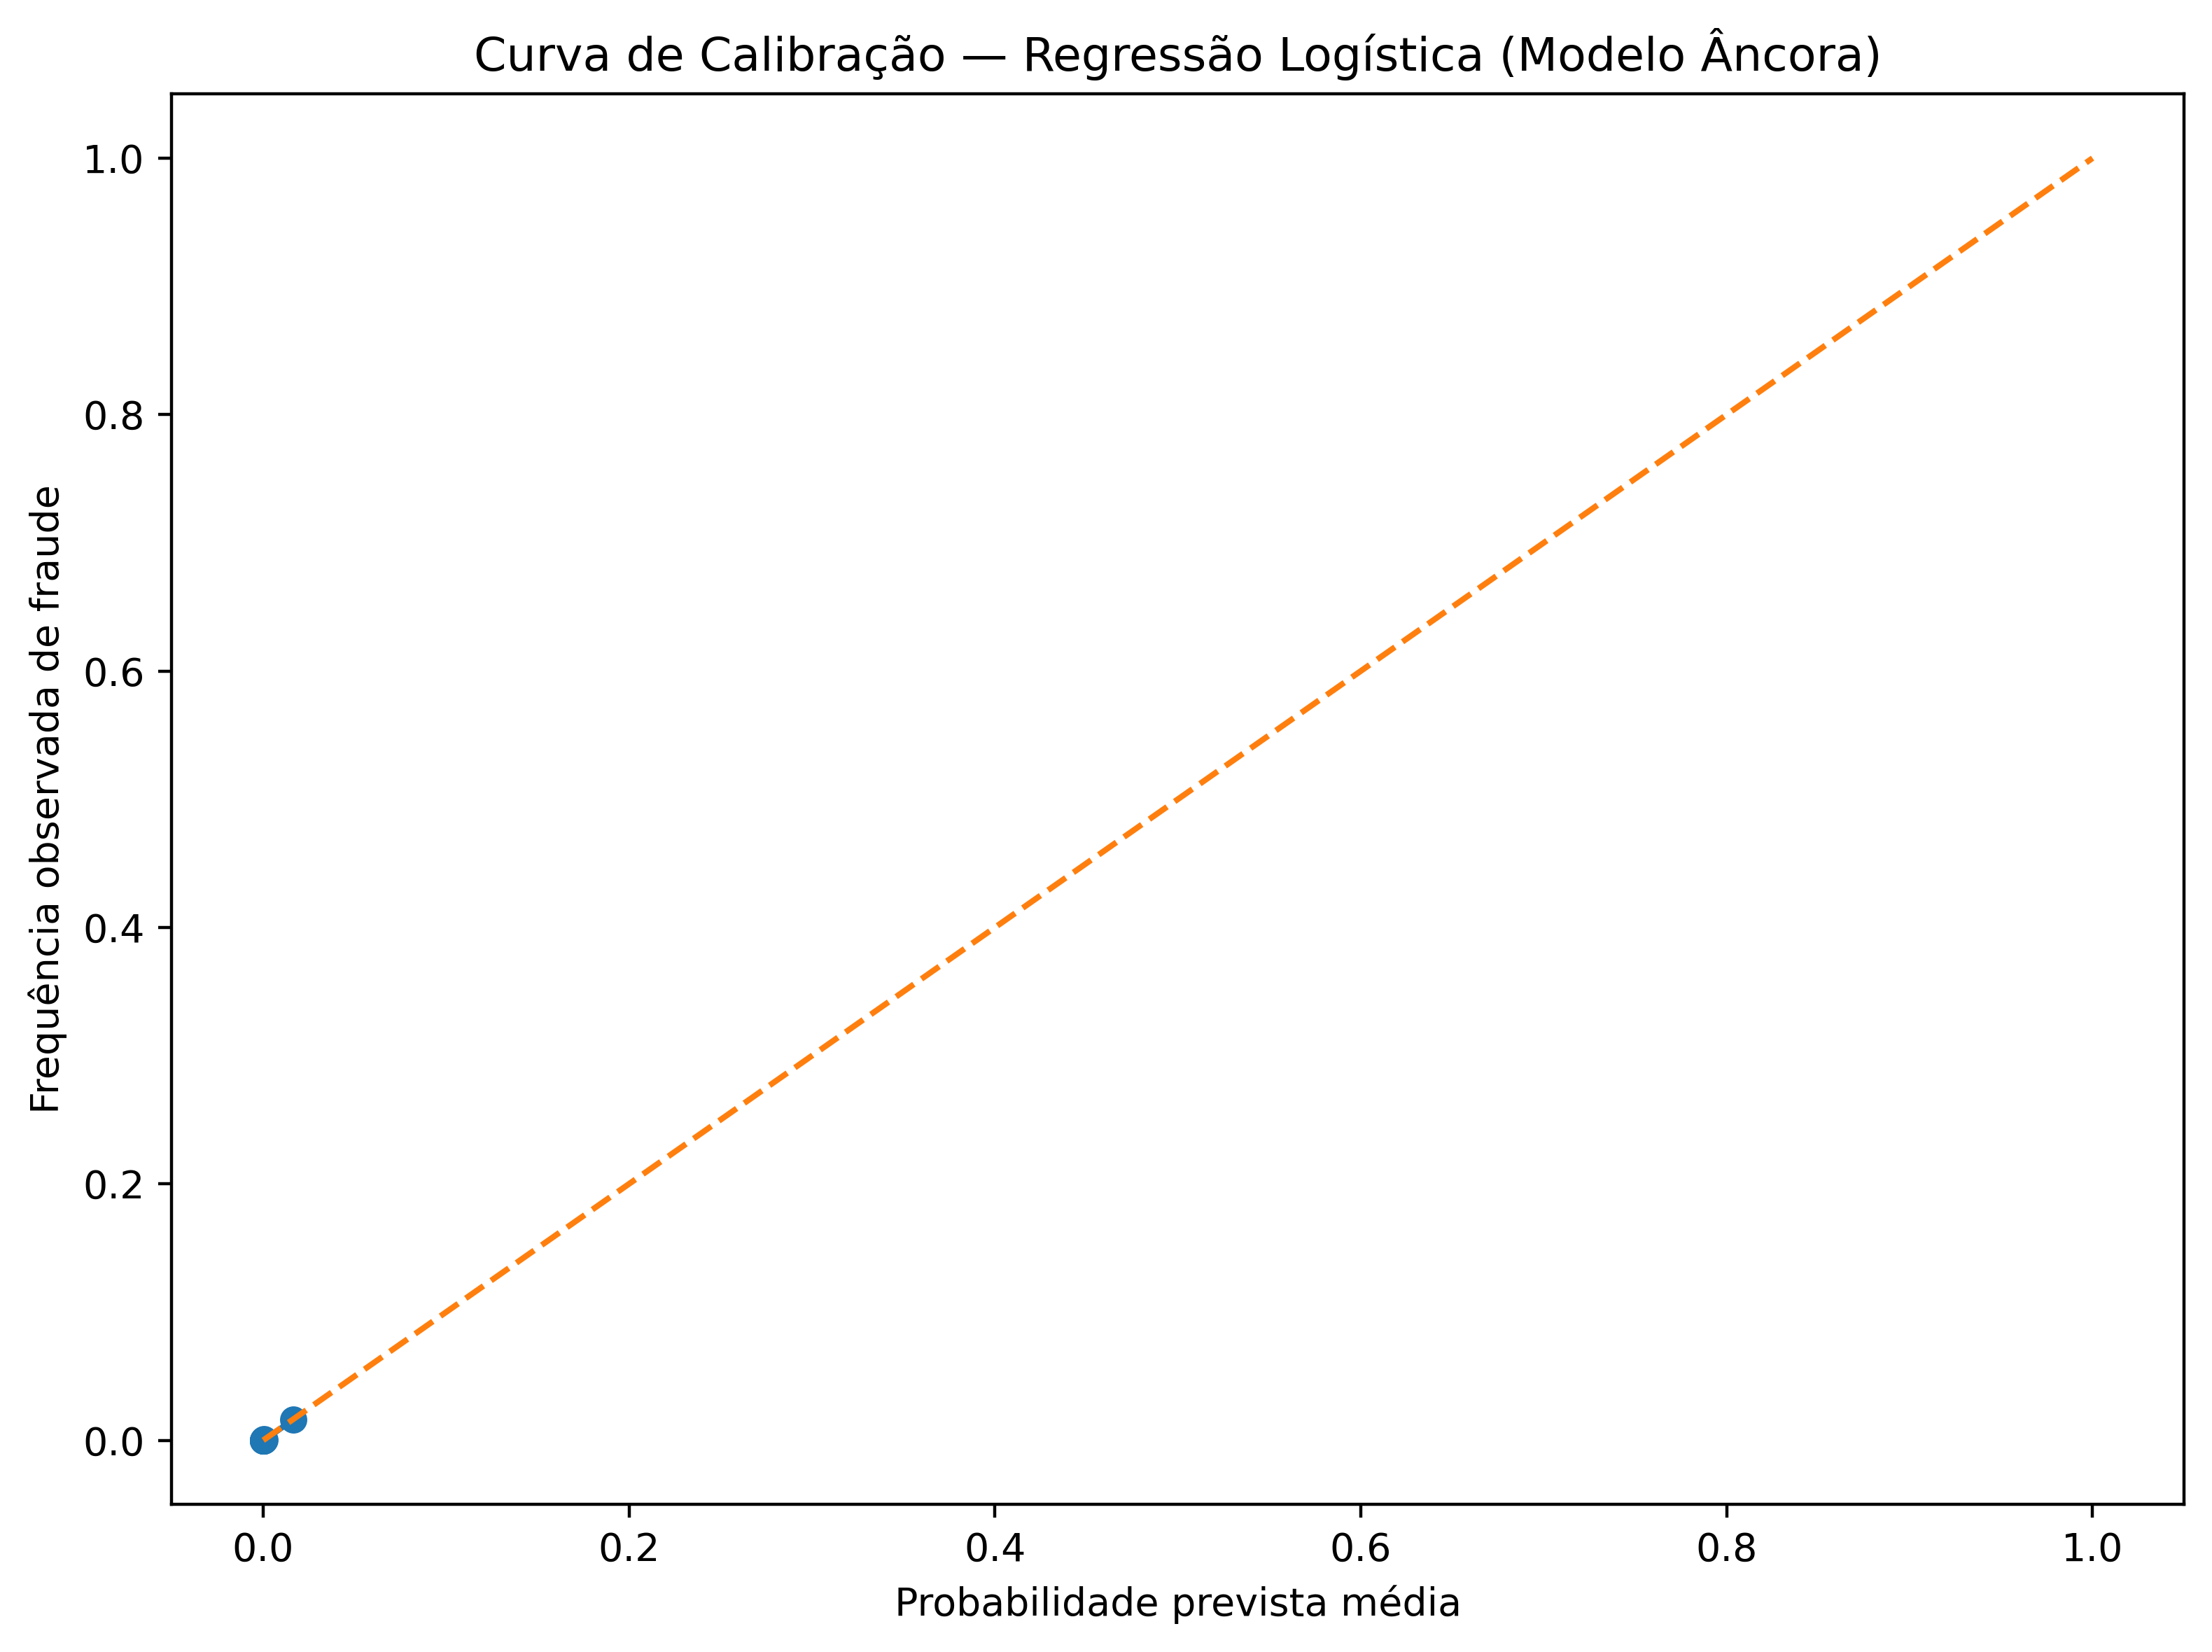

In [34]:
prob_true, prob_pred = calibration_curve(
    y_test,
    y_proba_test,
    n_bins=10,
    strategy="quantile"
)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Probabilidade prevista média")
plt.ylabel("Frequência observada de fraude")
plt.title("Curva de Calibração — Regressão Logística (Modelo Âncora)")
plt.tight_layout()
plt.show()


In [35]:
from sklearn.metrics import brier_score_loss

brier = brier_score_loss(y_test, y_proba_test)
print(f"Brier Score: {brier:.6f}")


Brier Score: 0.000653


In [36]:
def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(y_prob, bins) - 1

    ece = 0.0
    for i in range(n_bins):
        mask = bin_ids == i
        if np.any(mask):
            avg_confidence = y_prob[mask].mean()
            avg_accuracy = y_true[mask].mean()
            ece += np.abs(avg_confidence - avg_accuracy) * mask.mean()
    return ece

ece = expected_calibration_error(y_test, y_proba_test, n_bins=10)
print(f"ECE: {ece:.6f}")

ECE: 0.000409


O comportamento da curva de calibraçao era esperado devido ao forte desbalanceamento da classe positiva. A curva de calibração apresenta poucos pontos válidos, refletindo apenas regiões do espaço de probabilidade onde há incidência de fraudes. Como 99,8% dos exemplos são negativos, grande parte dos bins terá `y_true.mean() = 0`. Com poucos pontos, você não está avaliando a calibração global, e sim a calibração nas regiões onde o modelo concentra risco e o comportamento nas caudas de probabilidade. E isso é exatamente o que importa para decisão econômica. Lembre-se de que a pergunta correta neste momento é: **As probabilidades do modelo são utilizáveis para decisão econômica?** 

Adicionalmente, o Brier Score extremamente baixo sugere que o modelo atribui probabilidades muito próximas de 0 para a esmagadora maioria das transações legítimas e quando ele atribui probabilidade maior, isso ocorre em regiões onde há de fato mais fraudes. Embora um Brier Score reduzido, isoladamente, possa refletir apenas uma postura conservadora do modelo, sua interpretação ganha robustez quando analisada em conjunto com o ganho econômico positivo já observado. Isso sugere que o modelo não apenas evita previsões extremas indevidas, mas também atribui probabilidades informativas nas regiões onde a decisão de recusar transações gera benefício econômico.

Complementarmente, o valor de ECE, muito próximo de zero, indica que a discrepância média entre as probabilidades previstas e as frequências observadas de fraude é mínima. Evidenciando que o modelo âncora apresenta excelente calibração, mesmo em um contexto de forte desbalanceamento e baixa prevalência do evento positivo.

Por fim, a análise conjunta da curva de calibração, do Brier Score e do ECE permite concluir que o modelo de Regressão Logística apresenta probabilidades confiáveis e bem calibradas, adequadas para suportar políticas de decisão baseadas em risco. Não foram identificadas evidências de descalibração sistemática que justificassem a aplicação imediata de métodos adicionais de calibração, como Platt scaling ou regressão isotônica.

Dessa forma, o modelo âncora encontra-se em um estado metodologicamente sólido, com probabilidades preditas compatíveis com a etapa subsequente do projeto. A partir deste ponto, torna-se apropriado avançar para a otimização do limiar de decisão (threshold) com base na métrica de negócio, utilizando exclusivamente o conjunto de validação, de modo a maximizar o benefício econômico gerado pelo sistema de detecção de fraudes.

## Otimizando o Limiar de Decisão (threshold)

Antes de começarmos a nossa análise é importante estabelecer algumas considerações metodológicas para asegurar que:

- não haja vazamento de informação entre treino, validação e teste;

- o threshold seja tratado como parte da política de decisão, e não como hiperparâmetro do modelo;

- a otimização esteja alinhada diretamente com os objetivos econômicos do problema;

- os resultados obtidos são interpretáveis, auditáveis e replicáveis.

O procedimento adotado para otimizar o limiar de decisão consistiu nas seguintes etapas:

1. Geração das probabilidades preditas baseada no conjunto de validação.
2. Definição de uma grade de limiares candidatos (thresholds).
3. Avaliação econômica com base na métrica de negócio a partir das novas probabilidades convertidas em decisões binária com base em cada faixa de threshold da grade.
4. Identificar o limiar Ótimo que maximiza o valor da métrica de negócio no conjunto de validação, sem qualquer ajuste adicional de parâmetros do modelo.
5. Congelamento do Threshold ótimo no conjunto de validação e aplicação no conjunto de teste.
6. Avaliação do desempenho econômico obtido no teste com o baseline econômico definido previamente.

In [37]:
# Gerando as probabilidades baseada no conjunto de validação
y_proba_val = logit_anchor.predict_proba(X_val)[:, 1]

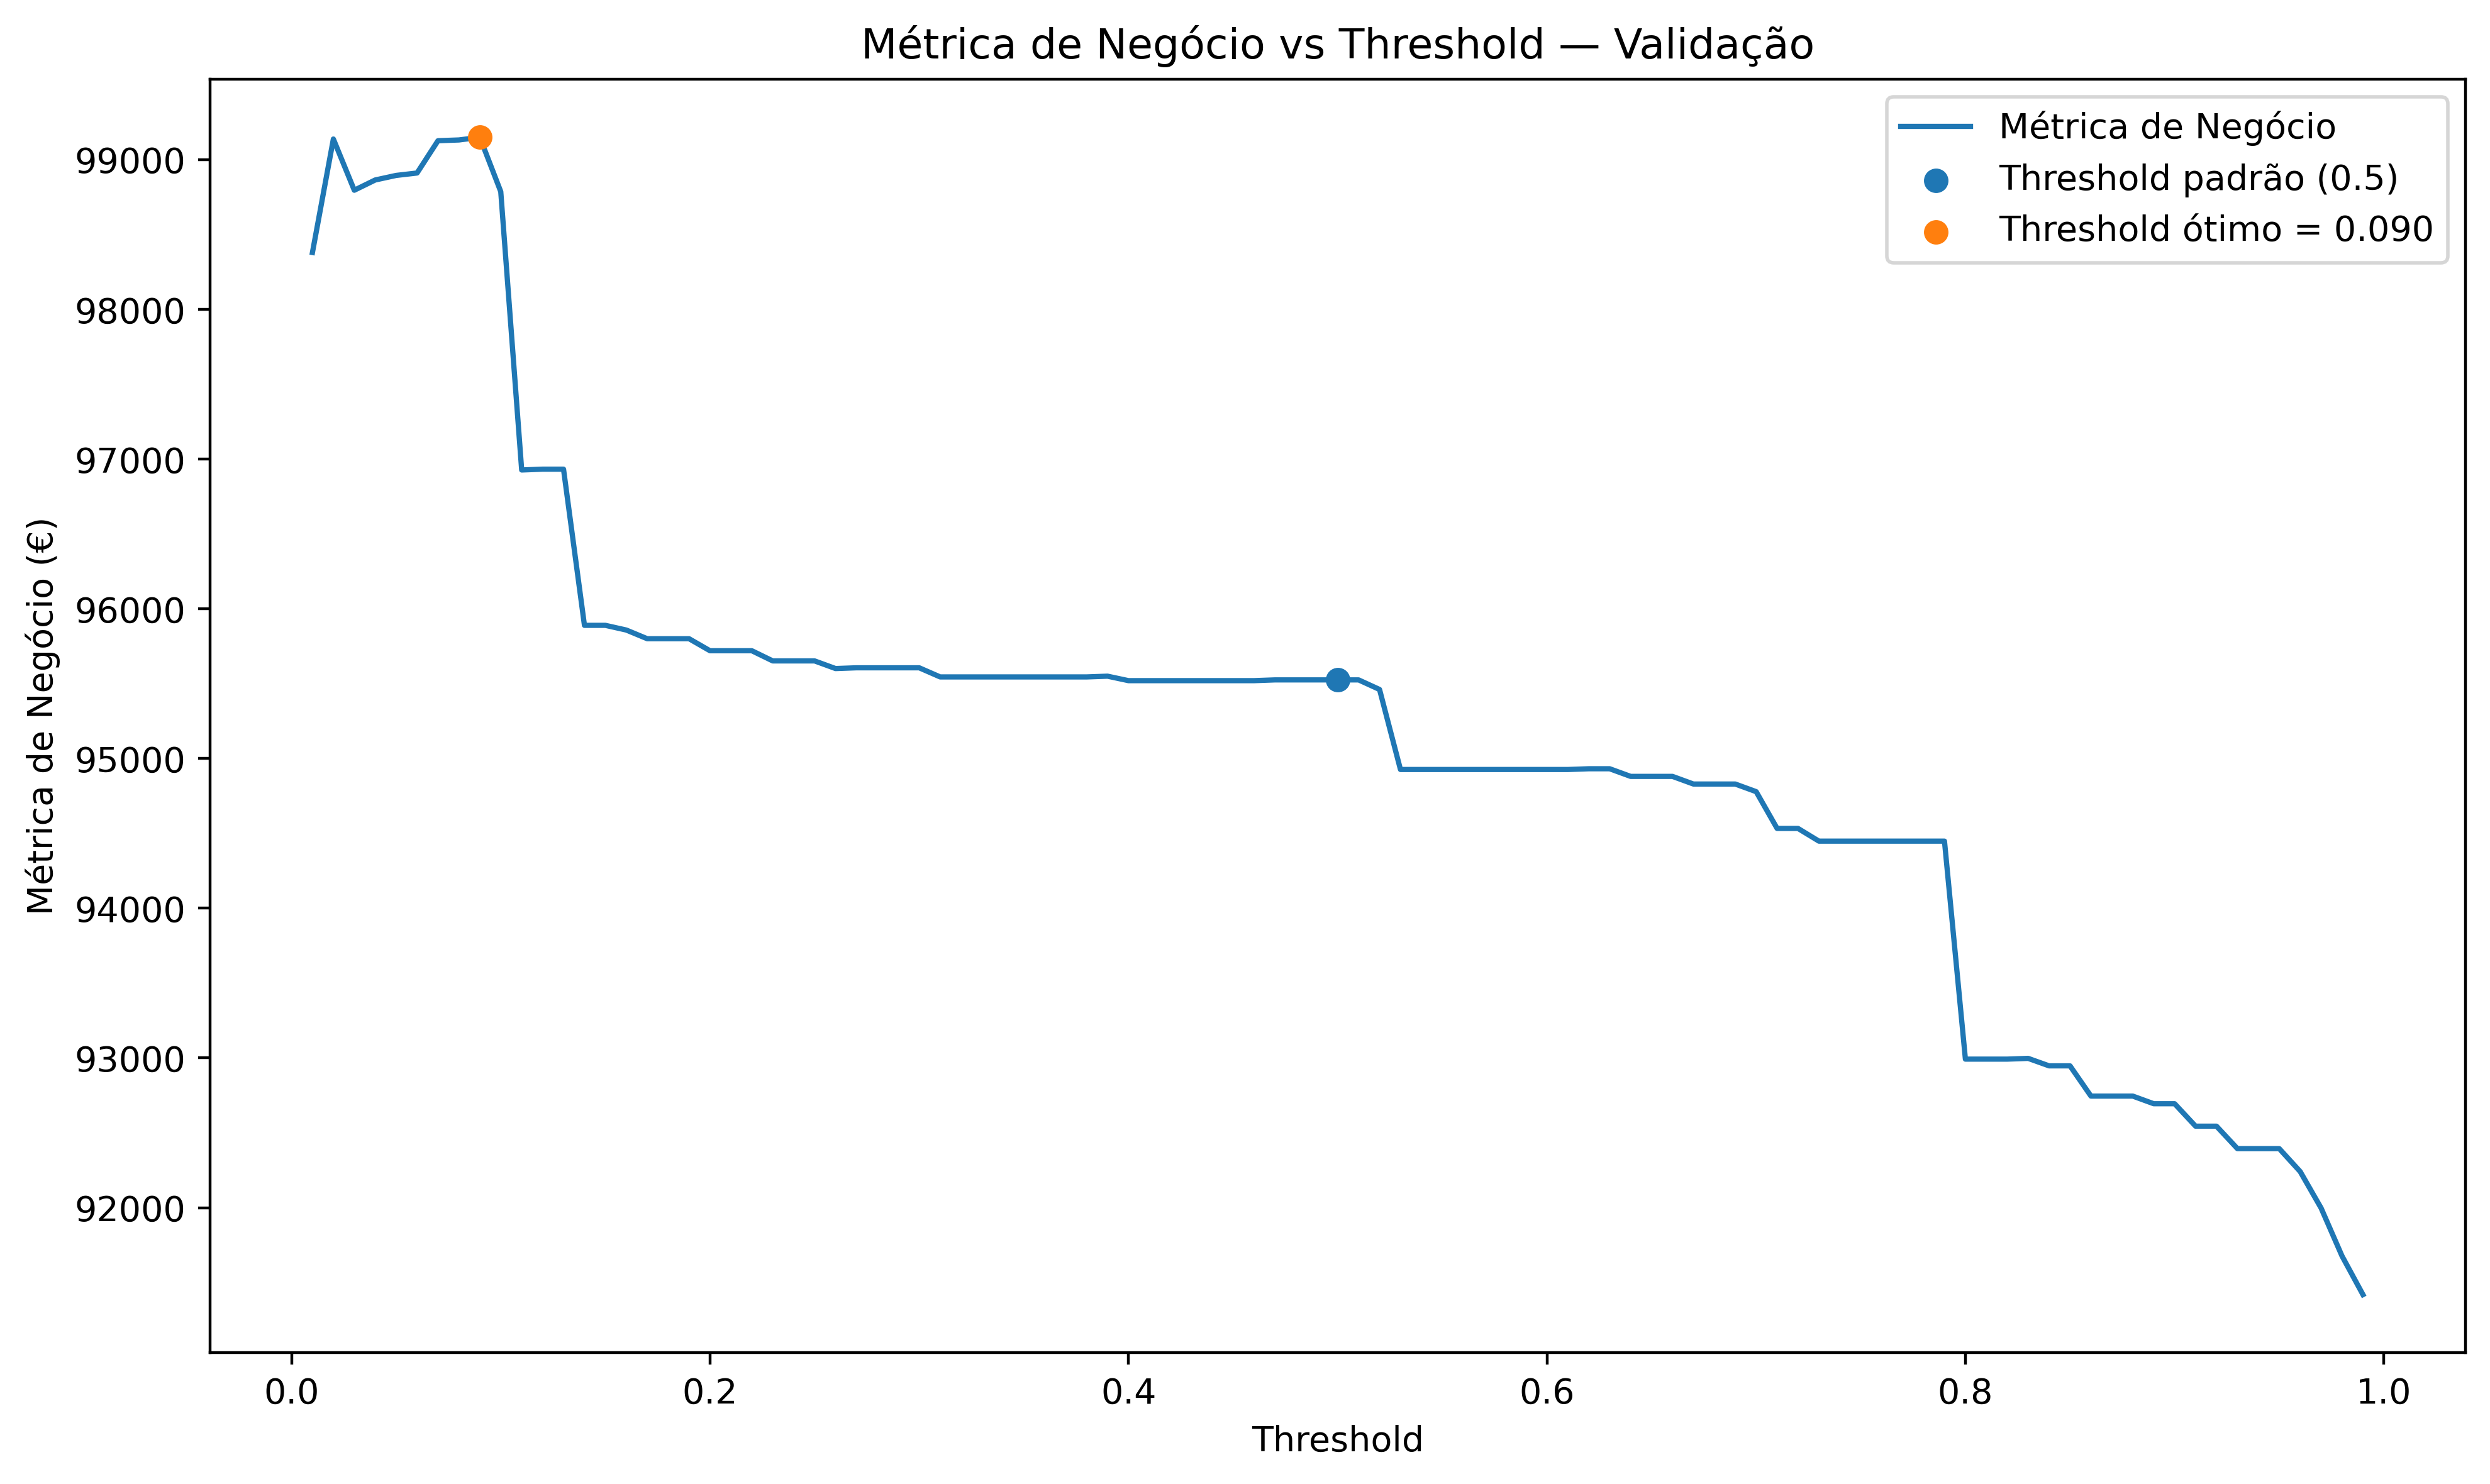

O Melhor threshold encontrado foi: 0.09


In [38]:
# definindo a grade de limiares de Threshold
thresholds = np.linspace(0.01, 0.99, 99)
business_values = []

for thr in thresholds:
    y_pred_thr = (y_proba_val >= thr).astype(int)
    business_values.append(
        business_metric(y_val, y_pred_thr, amount_val)
    )

business_values = np.array(business_values)

# Threshold ótimo
best_idx = np.argmax(business_values)
best_threshold = thresholds[best_idx]

# Índice do threshold padrão 0.5
idx_05 = np.argmin(np.abs(thresholds - 0.5))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, business_values, label="Métrica de Negócio")

# Ponto do threshold padrão
plt.scatter(
    thresholds[idx_05],
    business_values[idx_05],
    label="Threshold padrão (0.5)",
    zorder=3
)

# Ponto do threshold ótimo
plt.scatter(
    best_threshold,
    business_values[best_idx],
    label=f"Threshold ótimo = {best_threshold:.3f}",
    zorder=3
)

plt.xlabel("Threshold")
plt.ylabel("Métrica de Negócio (€)")
plt.title("Métrica de Negócio vs Threshold — Validação")
plt.legend()
plt.tight_layout()
plt.show()

best_threshold


print(f"O Melhor threshold encontrado foi: {best_threshold}")


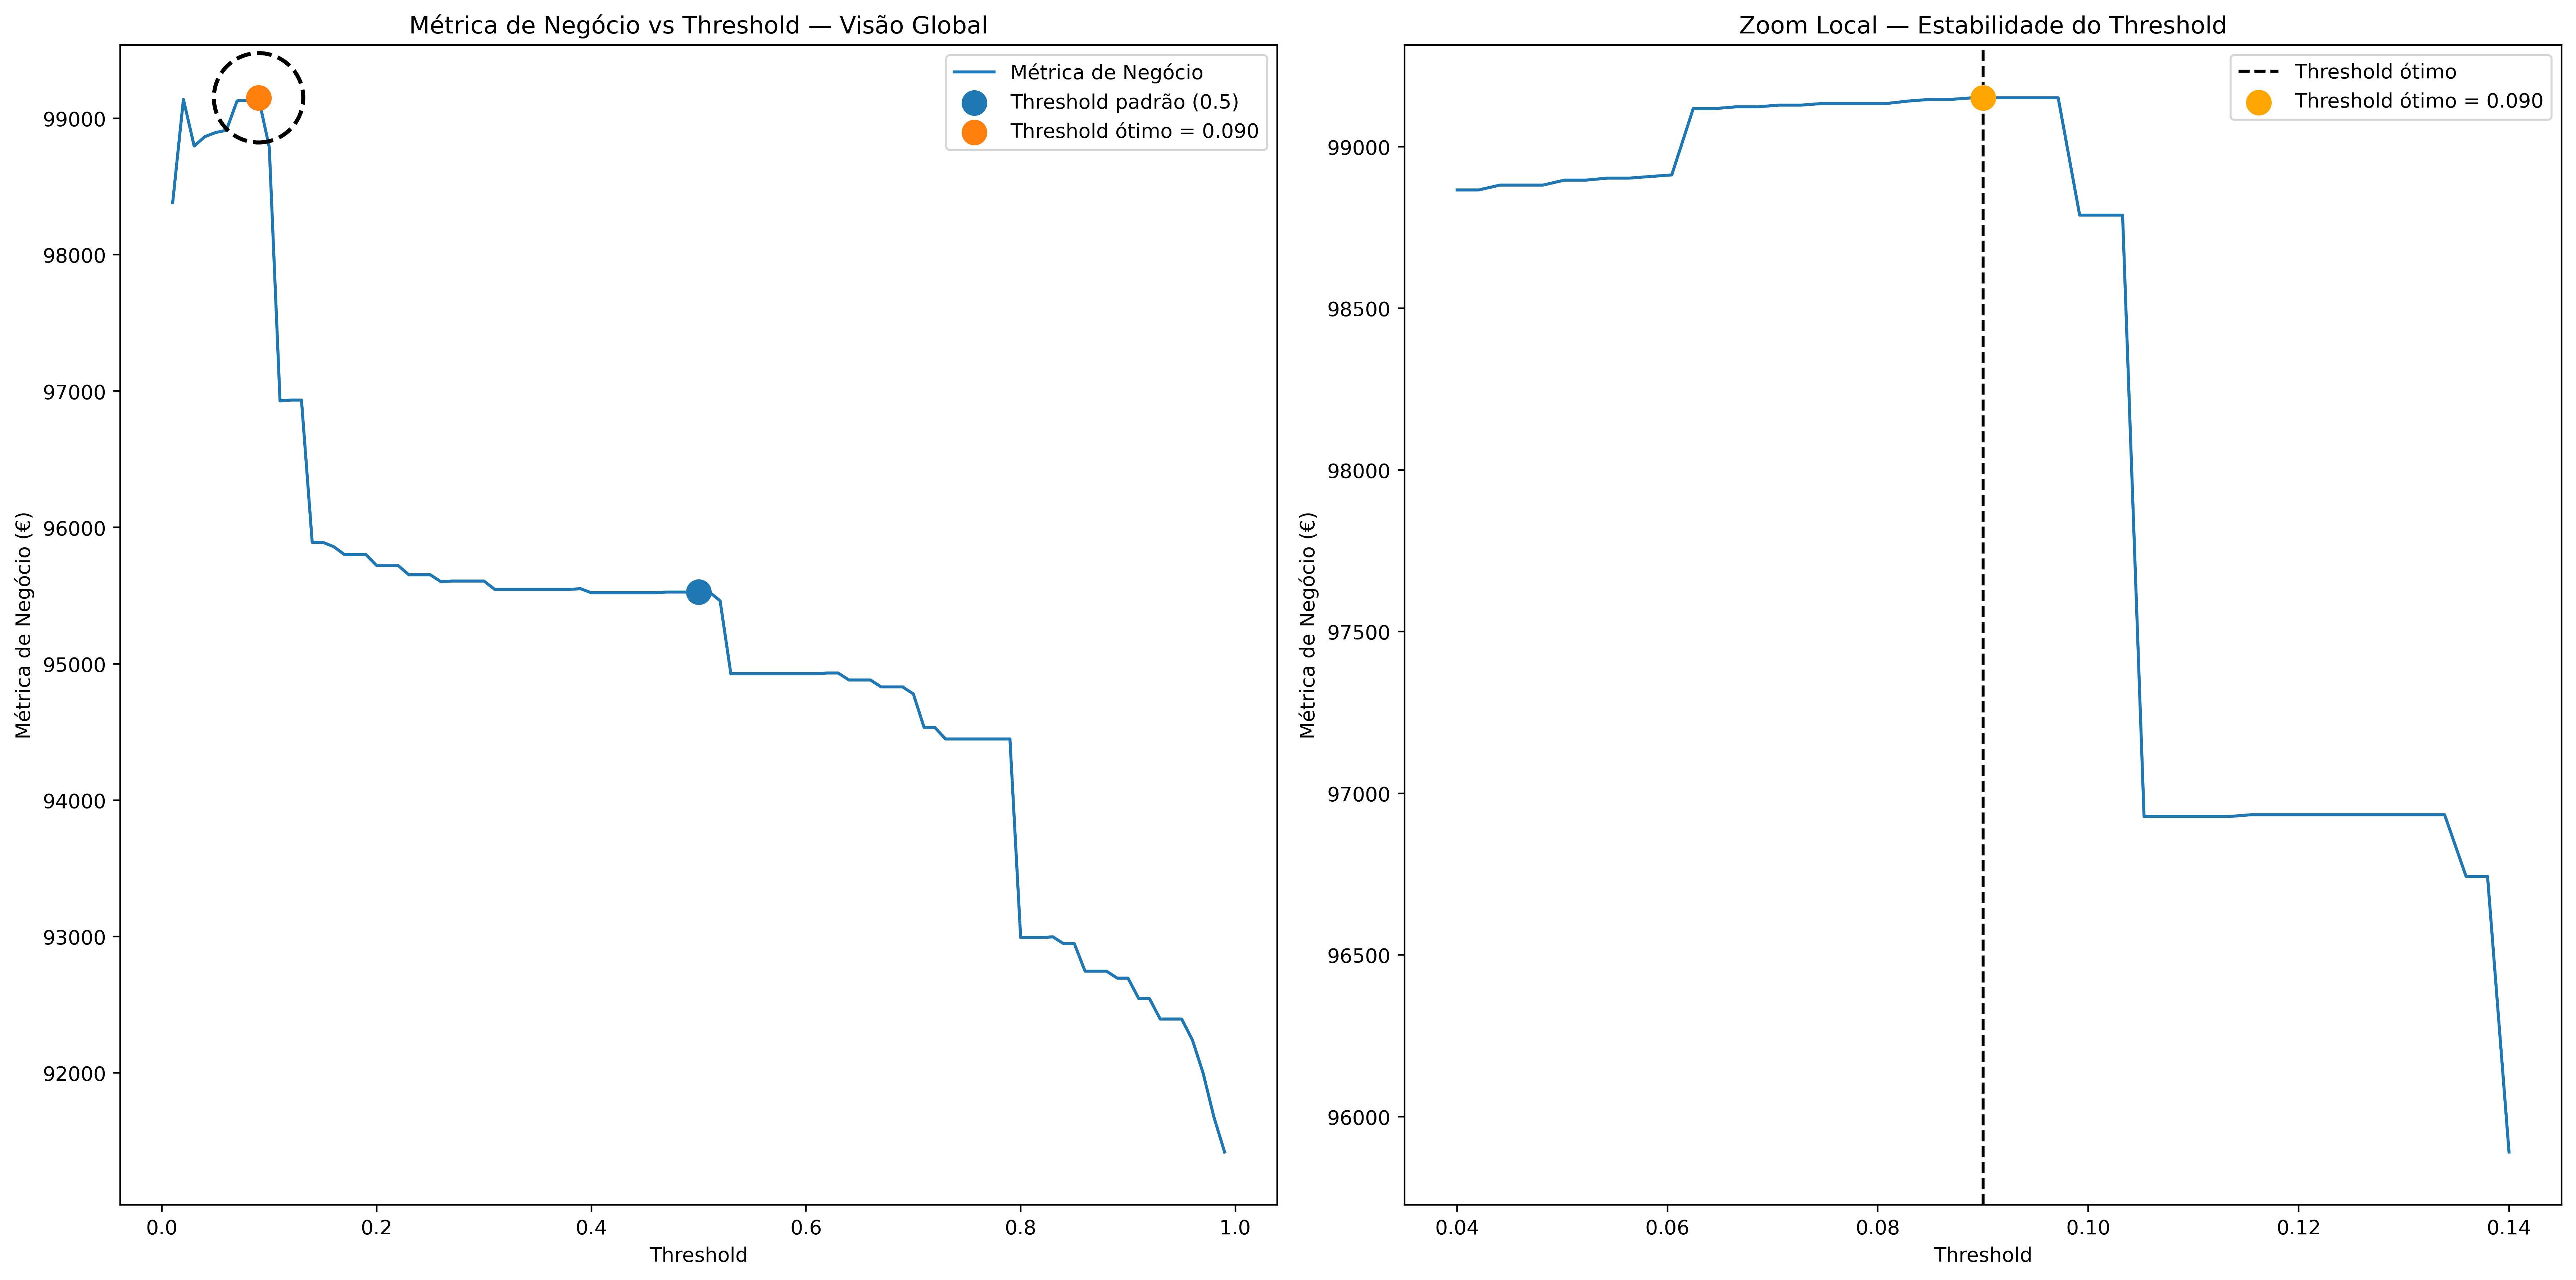

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

# (1) VISÃO GLOBAL
axes[0].plot(thresholds, business_values, label="Métrica de Negócio")

axes[0].scatter(
    thresholds[idx_05],
    business_values[idx_05],
    label="Threshold padrão (0.5)",
    zorder=4,
    s=140
)

axes[0].scatter(
    best_threshold,
    business_values[best_idx],
    label=f"Threshold ótimo = {best_threshold:.3f}",
    zorder=4,
    s=140
)

# Círculo pontilhado de destaque
axes[0].scatter(
    best_threshold,
    business_values[best_idx],
    s=2000,
    facecolors="none",
    edgecolors="black",
    linewidths=2,
    linestyle="--",
    zorder=3
)

axes[0].set_title("Métrica de Negócio vs Threshold — Visão Global")
axes[0].set_xlabel("Threshold")
axes[0].set_ylabel("Métrica de Negócio (€)")
axes[0].legend()


# (2) ZOOM LOCAL AO REDOR DO THRESHOLD ÓTIMO
delta = 0.05
local_thresholds = np.linspace(
    max(0.01, best_threshold - delta),
    min(0.99, best_threshold + delta),
    50
)

local_values = []

for thr in local_thresholds:
    y_pred = (y_proba_val >= thr).astype(int)
    local_values.append(
        business_metric(y_val, y_pred, amount_val)
    )

axes[1].plot(local_thresholds, local_values)

axes[1].axvline(
    best_threshold,
    linestyle="--",
    label="Threshold ótimo",
    color='black'
)

axes[1].scatter(
    best_threshold,
    business_values[best_idx],
    label=f"Threshold ótimo = {best_threshold:.3f}",
    color="orange",
    zorder=4,
    s=140
)

axes[1].set_title("Zoom Local — Estabilidade do Threshold")
axes[1].set_xlabel("Threshold")
axes[1].set_ylabel("Métrica de Negócio (€)")
axes[1].legend()

plt.tight_layout()
plt.show()

A análise de estabilidade local do limiar de decisão foi realizada em torno do threshold ótimo identificado no conjunto de validação. Observa-se que o limiar ótimo está inserido em um platô relativamente amplo de desempenho econômico máximo, indicando que pequenas variações no threshold não resultam em degradação significativa da métrica de negócio. No entanto, a partir de valores superiores a aproximadamente 0.10, ocorre uma queda abrupta no benefício econômico, sugerindo um aumento excessivo de rejeições indevidas. Esses resultados indicam que a política de decisão é robusta dentro de uma faixa operacional segura, ao mesmo tempo em que delimitam claramente regiões de risco para a tomada de decisão.

Embora o threshold ótimo estimado seja 0,09, qualquer valor dentro do intervalo entre 0.07 - 0.09, apresenta desempenho econômico equivalente, permitindo flexibilidade operacional sem perda relevante de valor.

In [40]:
# avaliando o modelo com o threshold otimizado
y_pred_test_opt = (y_proba_test >= best_threshold).astype(int)

business_test_opt = business_metric(
    y_test,
    y_pred_test_opt,
    amount_test
)

print(f"Métrica de Negócio com o Threshold Ótimo: {business_test_opt:,.2f}€")

Métrica de Negócio com o Threshold Ótimo: 101,457.27€


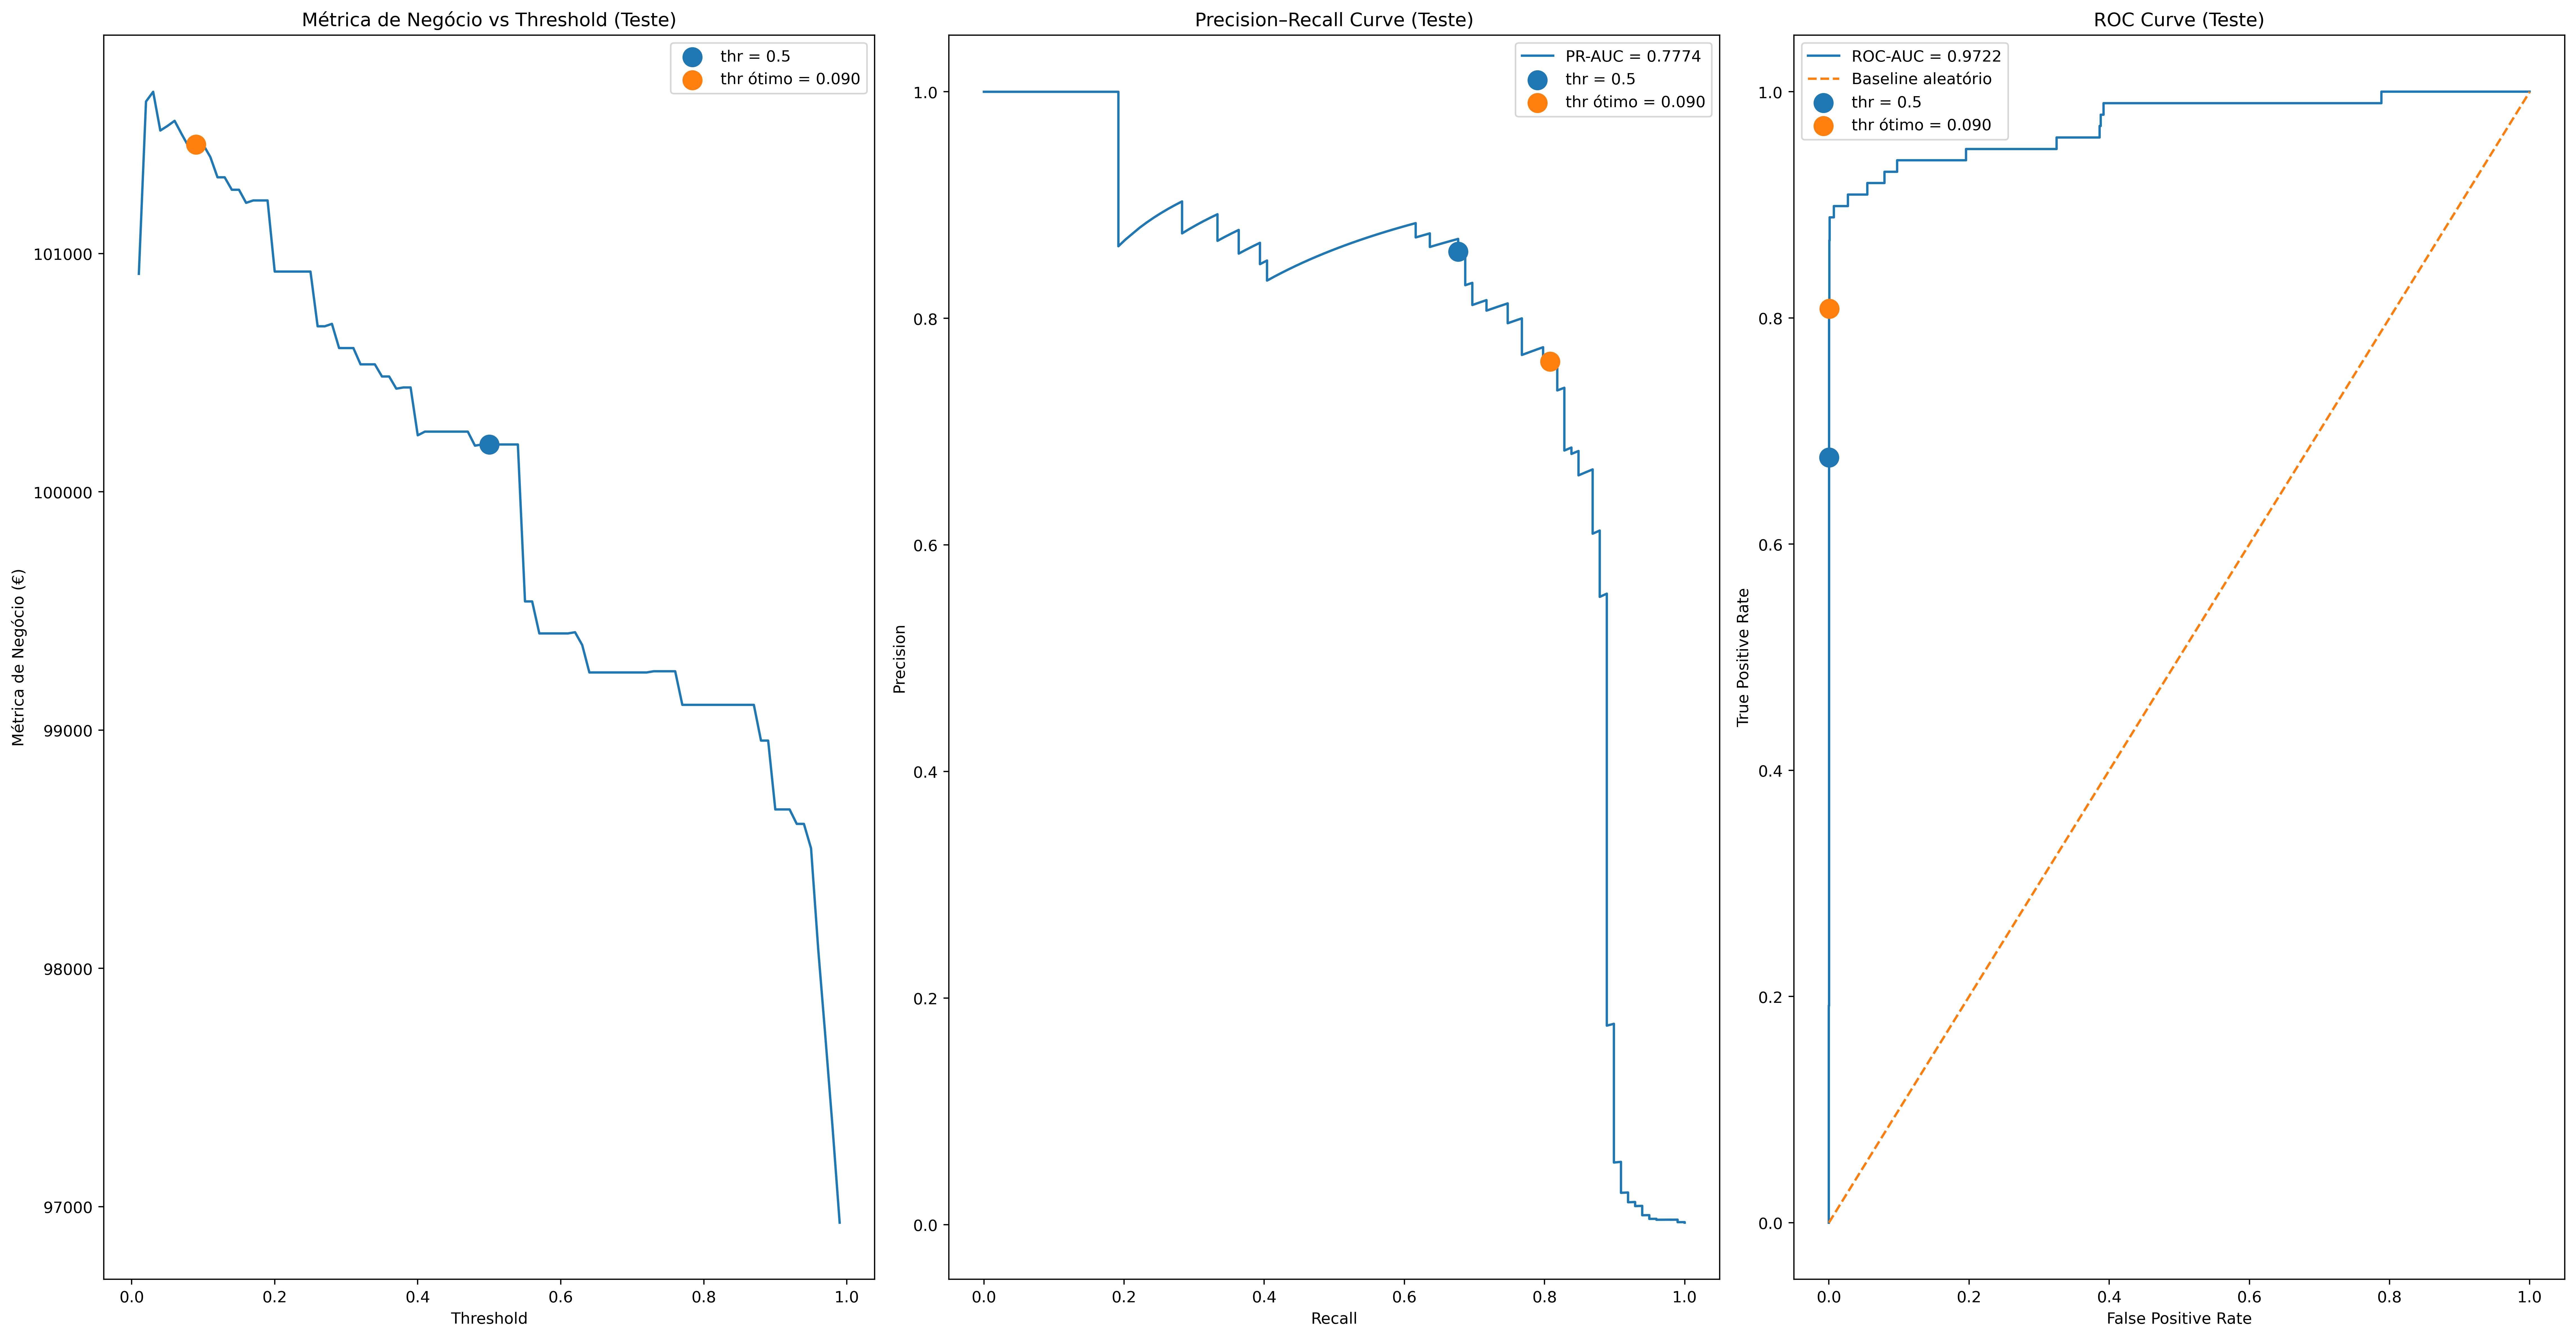

In [41]:
# 1. MÉTRICA DE NEGÓCIO vs THRESHOLD — TESTE
thresholds = np.linspace(0.01, 0.99, 99)
business_values_test = []

for thr in thresholds:
    y_pred_thr = (y_proba_test >= thr).astype(int)
    business_values_test.append(
        business_metric(y_test, y_pred_thr, amount_test)
    )

business_values_test = np.array(business_values_test)

# Índices dos thresholds
idx_05 = np.argmin(np.abs(thresholds - 0.5))
idx_opt = np.argmin(np.abs(thresholds - best_threshold))

# 2. PRECISION–RECALL — TESTE
precision, recall, pr_thresholds = precision_recall_curve(
    y_test, y_proba_test
)
pr_auc = average_precision_score(y_test, y_proba_test)

def find_closest_threshold(thresholds, target):
    return np.argmin(np.abs(thresholds - target))

idx_05_pr = find_closest_threshold(pr_thresholds, 0.5)
idx_opt_pr = find_closest_threshold(pr_thresholds, best_threshold)

# 3. ROC — TESTE
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)

idx_05_roc = find_closest_threshold(roc_thresholds, 0.5)
idx_opt_roc = find_closest_threshold(roc_thresholds, best_threshold)


# 4. SUBPLOT CONSOLIDADO
fig, axes = plt.subplots(1, 3, figsize=(23, 12), dpi=400)

# --- (1) Métrica de Negócio vs Threshold ---
axes[0].plot(thresholds, business_values_test)
axes[0].scatter(
    thresholds[idx_05],
    business_values_test[idx_05],
    label="thr = 0.5",
    zorder=4,
    s=140
)
axes[0].scatter(
    thresholds[idx_opt],
    business_values_test[idx_opt],
    label=f"thr ótimo = {best_threshold:.3f}",
    zorder=4,
    s=140
)
axes[0].set_title("Métrica de Negócio vs Threshold (Teste)")
axes[0].set_xlabel("Threshold")
axes[0].set_ylabel("Métrica de Negócio (€)")
axes[0].legend()

# --- (2) Precision–Recall ---
axes[1].plot(recall, precision, label=f"PR-AUC = {pr_auc:.4f}")
axes[1].scatter(
    recall[idx_05_pr],
    precision[idx_05_pr],
    label="thr = 0.5",
    zorder=4,
    s=140
)
axes[1].scatter(
    recall[idx_opt_pr],
    precision[idx_opt_pr],
    label=f"thr ótimo = {best_threshold:.3f}",
    zorder=4,
    s=140
)
axes[1].set_title("Precision–Recall Curve (Teste)")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].legend()

# --- (3) ROC ---
axes[2].plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.4f}")
axes[2].plot(
    [0, 1],
    [0, 1],
    linestyle="--",
    label="Baseline aleatório"
)
axes[2].scatter(
    fpr[idx_05_roc],
    tpr[idx_05_roc],
    label="thr = 0.5",
    zorder=4,
    s=140
)
axes[2].scatter(
    fpr[idx_opt_roc],
    tpr[idx_opt_roc],
    label=f"thr ótimo = {best_threshold:.3f}",
    zorder=4,
    s=140
)
axes[2].set_title("ROC Curve (Teste)")
axes[2].set_xlabel("False Positive Rate")
axes[2].set_ylabel("True Positive Rate")
axes[2].legend()

plt.tight_layout()
plt.show()


Após a avaliação do modelo âncora de Regressão Logística com o limiar de decisão padrão (0,5), procedeu-se à otimização do threshold com base na métrica de negócio definida, utilizando exclusivamente o conjunto de validação. O objetivo dessa etapa foi maximizar o benefício econômico da política de decisão, explorando de forma mais eficiente o trade-off entre a aceitação de transações legítimas e o bloqueio de fraudes, em um contexto explicitamente sensível a custo.

O limiar ótimo identificado no conjunto de validação foi então congelado e aplicado ao conjunto de teste, assegurando uma avaliação estritamente out-of-sample e evitando qualquer forma de vazamento de informação. No conjunto de teste, a política baseada no threshold padrão já apresentou um benefício econômico de € 100.198,80, superando o baseline econômico de € 90.280,45 associado à política de aprovar todas as transações.

Com a aplicação do threshold otimizado, o benefício econômico no conjunto de teste aumentou para € 101.457,27, representando um ganho adicional de € 1.258,47 em relação ao limiar padrão e um ganho total de € 11.176,82 em relação ao baseline econômico. Esse incremento corresponde a aproximadamente **12,4% de aumento no valor econômico** gerado, evidenciando o impacto direto da otimização da política de decisão, independentemente de alterações na estrutura ou complexidade do modelo preditivo.

Cabe destacar que o limiar ótimo, definido com base no conjunto de validação, não coincide necessariamente com o ponto de máximo empírico da métrica de negócio quando esta é recalculada ao longo de todo o intervalo de thresholds no conjunto de teste. Esse comportamento é esperado e decorre da natureza empírica da função objetivo, que é estimada a partir de amostras finitas e altamente desbalanceadas, nas quais poucos eventos de alto impacto financeiro podem deslocar o ponto exato de máximo. O critério relevante, portanto, não é a maximização pontual no teste, mas a permanência do limiar escolhido em uma região próxima ao topo da curva de desempenho econômico, preservando a maior parte do ganho observado.

Em conjunto, esses resultados demonstram que a otimização do limiar de decisão é uma etapa fundamental em problemas de detecção de fraudes sensíveis a custo, permitindo extrair valor econômico adicional mesmo a partir de modelos simples e bem calibrados. Além disso, a estabilidade do desempenho observada no conjunto de teste sugere que o ganho obtido decorre de uma política de decisão generalizável, e não de um ajuste oportunista aos dados, reforçando a robustez metodológica da abordagem adotada e descartando a possibilidade de um possível overfitting.

## Análise Econômica do Impacto das Fraudes e Mitigação pelo Modelo

Além da avaliação do desempenho econômico relativo do modelo em comparação com a política de aprovar todas as transações, vamos realizar agora uma análise específica do impacto financeiro das fraudes no período observado e da capacidade do modelo em mitigar esse impacto.

Para esta análise vamos seguir as seguintes etapas:

1. Calcular o **Impacto Financeiro Bruto das Fraudes** considerando a soma do valor (`Amount`) de todas as transações rotuladas como fraude (`Class = 1`). Esse valor representará o `prejuizo total` causado pelas transações fraudulentas durante o período de análises.
2. Calcular o **Prejuízo gerado pela Fraude Residual** que corresponde ao valor total das transações fraudulentas que não foram detectadas pelo modelo, isto é, aquelas classificadas como legítimas (falsos negativos).
3. Calcular o **valor financeiro das fraudes efetivamente evitadas** pela política baseada no modelo. Esse valor corresponde a diferença entre o `prejuízo total` e o `prejuízo residual`.
4. Calcular o **percentual de mitigação do impacto financeiro das fraudes** definido como a razão entre o valor evitado e o prejuízo total causado pelas fraudes no período analisado.


O conjunto de dados utilizado compreende aproximadamente dois dias de transações, conforme verificado a partir da variável `Time`, que representa o tempo transcorrido desde a primeira até a última transação registrada. Embora essa variável não corresponda a uma marcação temporal absoluta, ela permite inferir com razoável precisão a duração do período analisado.

In [42]:
# Impacto Financeiro Bruto das Fraudes
prejuizo_total_fraude = amount_test[y_test == 1].sum()

print(f"O Impacto Financeiro gerado pelas transações Fraudulentas foi de € {prejuizo_total_fraude:,.2f}")

O Impacto Financeiro gerado pelas transações Fraudulentas foi de € 9,874.35


In [43]:
# Prejuízo residual: fraudes aceitas pelo modelo (FN)
prejuizo_residual_modelo = amount_test[
    (y_test == 1) & (y_pred_test_opt == 0)
].sum()

print(f"O Valor total das transações fraudulentas que não foram detectadas pelo modelo foi de € {prejuizo_residual_modelo:,.2f}")

O Valor total das transações fraudulentas que não foram detectadas pelo modelo foi de € 2,563.08


In [44]:
# Valor evitado pelo modelo
fraude_evitada = prejuizo_total_fraude - prejuizo_residual_modelo

print(f"Total do montante resultante das fraudes efetivamente evitadas foi de € {fraude_evitada:,.2f}")

Total do montante resultante das fraudes efetivamente evitadas foi de € 7,311.27


In [45]:
# percentual de mitigação de fraudes
percentual_fraude_mitigada = fraude_evitada / prejuizo_total_fraude

print(f"O modelo conseguiu mitigar {percentual_fraude_mitigada * 100:.2f}% do prejuízo causado pelas fraudes")

O modelo conseguiu mitigar 74.04% do prejuízo causado pelas fraudes


O modelo foi capaz de mitigar aproximadamente 74,6% do impacto financeiro bruto das fraudes no período analisado. Quando considerados conjuntamente os efeitos de perdas por fraudes residuais, custos de rejeições indevidas e ganhos associados à aceitação de transações legítimas, essa mitigação se traduziu em um aumento de aproximadamente 12,4% no benefício econômico líquido em relação à política de aprovar todas as transações.

## Avaliação Econômica do Modelo Âncora

Com a métrica de negócio devidamente definida e os baselines econômicos estabelecidos, foi realizada a avaliação do modelo âncora de Regressão Logística no conjunto de teste, utilizando o limiar de decisão padrão (0,5). O objetivo desta etapa foi verificar se um modelo supervisionado simples, sem qualquer ajuste adicional, já seria capaz de superar uma política operacional ingênua.

Como referência, foi considerada a política de aprovar todas as transações, que representa a ausência de qualquer mecanismo de controle antifraude. Essa política gera valor econômico apenas por meio da aceitação de transações legítimas, mas incorre em perdas proporcionais ao valor total das fraudes aceitas.

Do ponto de vista metodológico, esse achado é relevante porque valida três premissas fundamentais do projeto:
(i) existe sinal preditivo nos dados capaz de ser explorado por um modelo supervisionado simples;
(ii) a métrica de negócio adotada é capaz de diferenciar políticas de decisão de forma consistente;
(iii) o pipeline de modelagem e avaliação está corretamente implementado, sem vazamento de informação ou distorções operacionais.

A partir desse ponto, o modelo de regressão logística passa a servir como referência econômica mínima para etapas posteriores do projeto, nas quais serão explorados ajustes de política de decisão (como otimização de threshold) e eventuais melhorias no modelo, sempre com base em ganhos econômicos adicionais e avaliados de forma estritamente out-of-sample.

## Matriz de Confusão

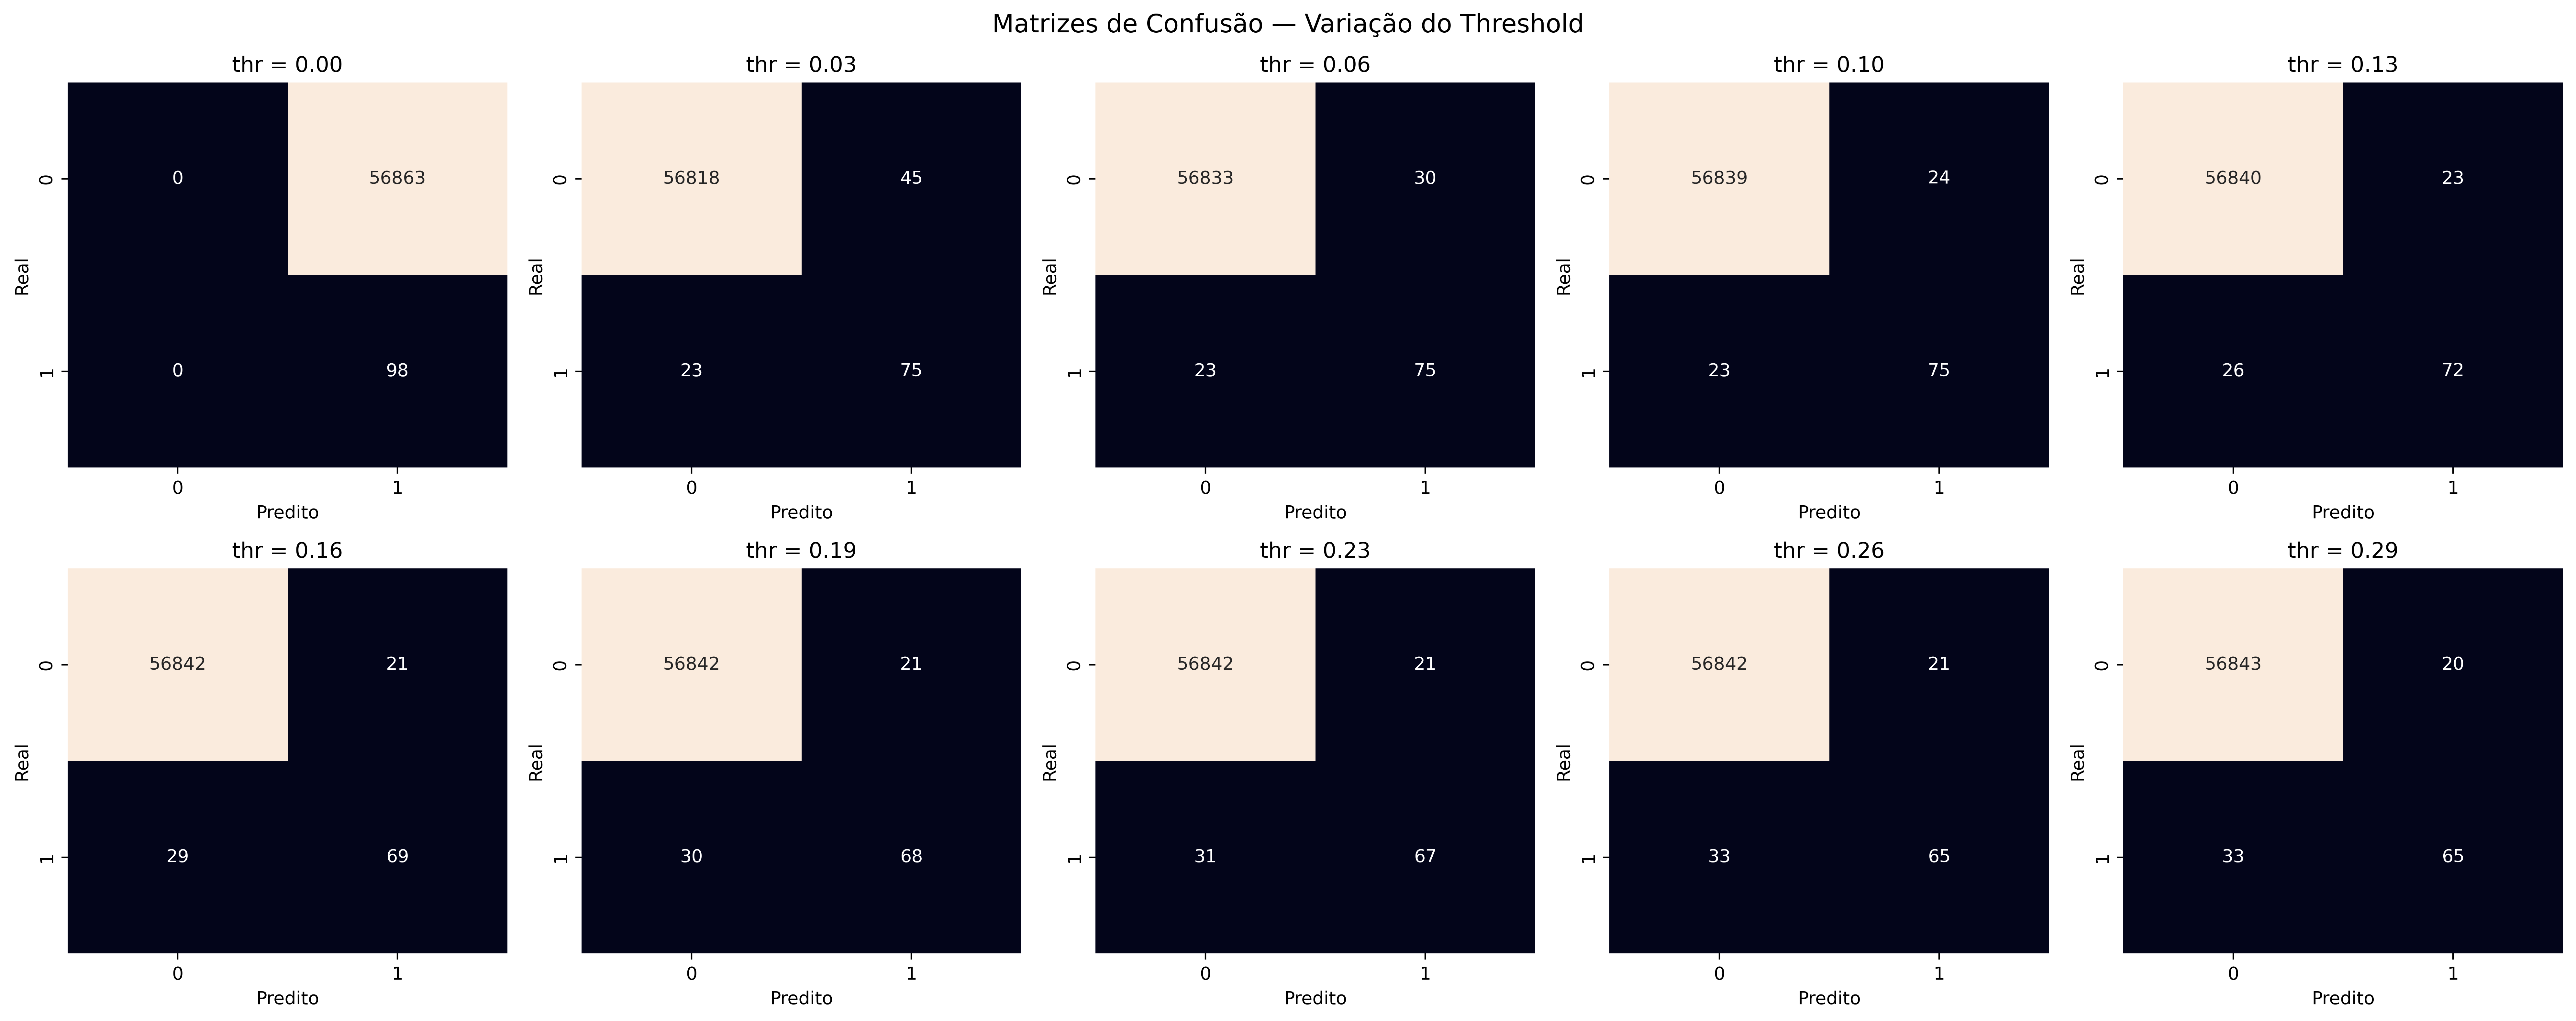

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

threshold_grid = np.linspace(
    max(0, best_threshold - 0.2),
    min(1, best_threshold + 0.2),
    10
)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for ax, thr in zip(axes.flatten(), threshold_grid):
    y_pred_thr = (y_proba_val >= thr).astype(int)
    cm = confusion_matrix(y_val, y_pred_thr)

    sns.heatmap(cm, annot=True, fmt="d", cbar=False, ax=ax)
    ax.set_title(f"thr = {thr:.2f}")
    ax.set_xlabel("Predito")
    ax.set_ylabel("Real")

plt.suptitle("Matrizes de Confusão — Variação do Threshold", fontsize=14)
plt.tight_layout()
plt.show()


## Analisando a Estabilidade do Modelo

### Learning Curve

In [47]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

train_sizes, train_scores, val_scores = learning_curve(
    estimator=logit_anchor,
    X=X_train,
    y=y_train,
    cv=cv,
    scoring="roc_auc",
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Médias e desvios
train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)

val_mean = val_scores.mean(axis=1)
val_std  = val_scores.std(axis=1)

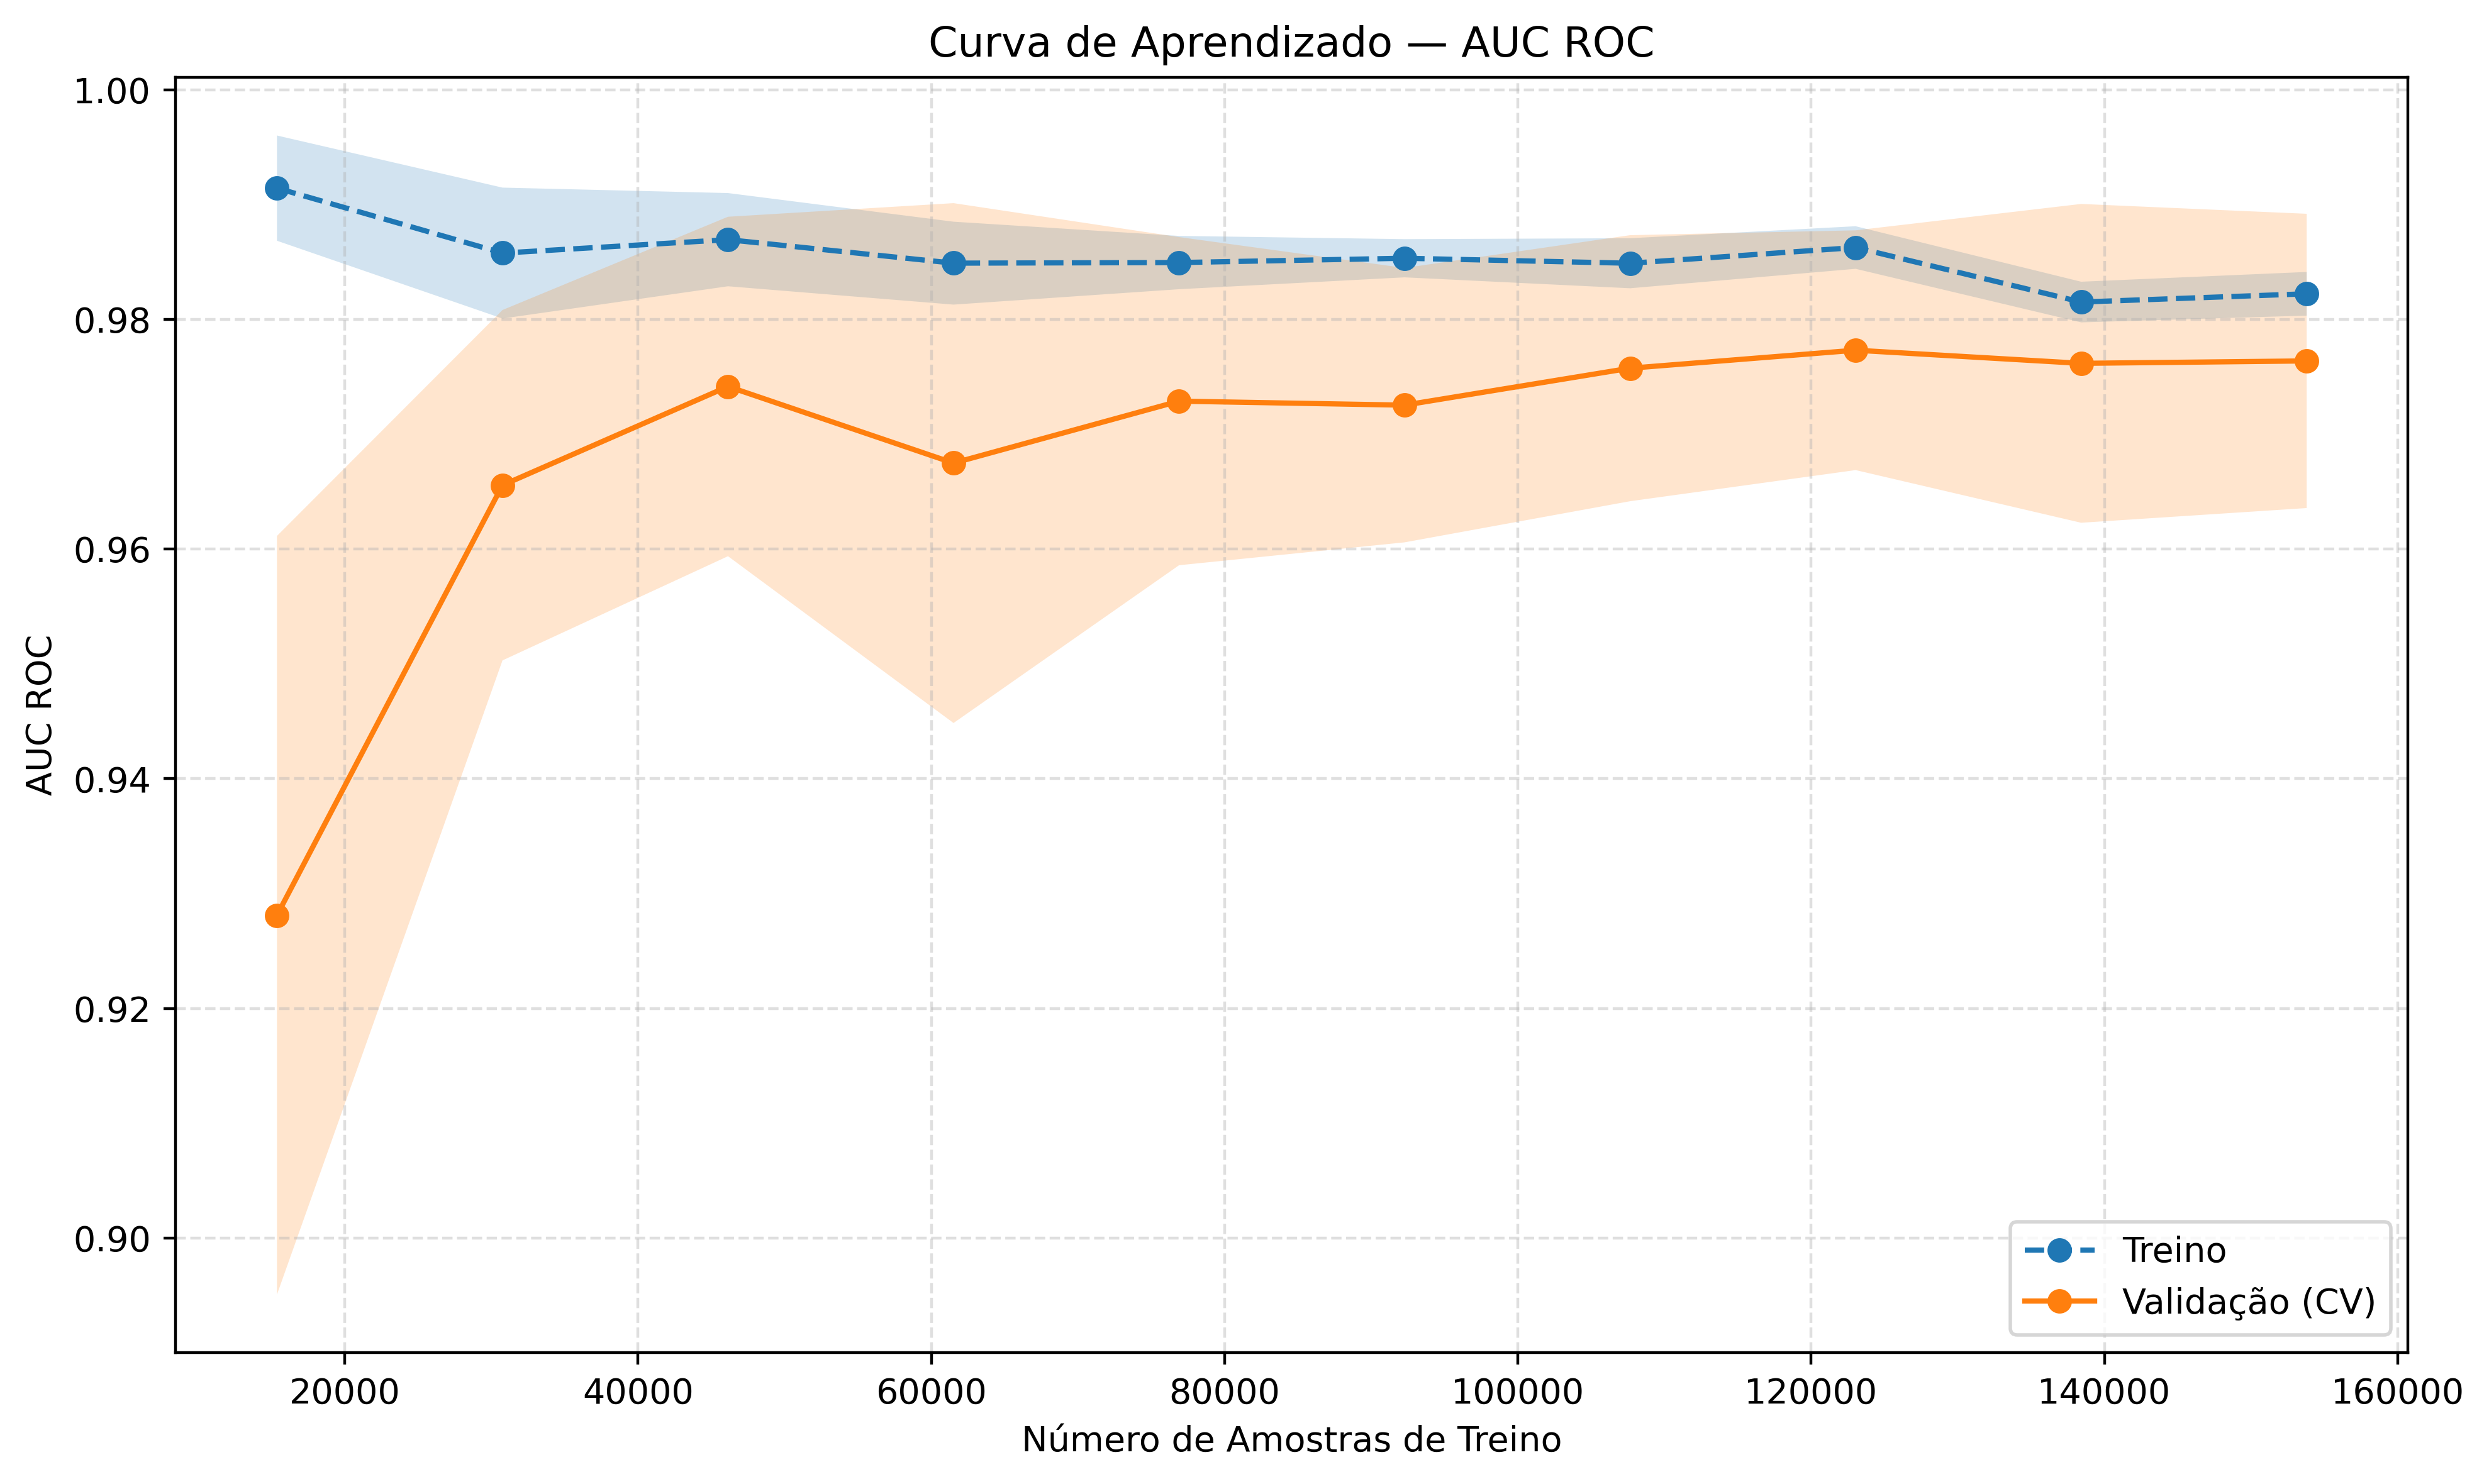

In [48]:
plt.figure(figsize=(10, 6))

# Curva de treino
plt.plot(
    train_sizes,
    train_mean,
    marker="o",
    linestyle="--",
    label="Treino"
)
plt.fill_between(
    train_sizes,
    train_mean - train_std,
    train_mean + train_std,
    alpha=0.2
)

# Curva de validação
plt.plot(
    train_sizes,
    val_mean,
    marker="o",
    linestyle="-",
    label="Validação (CV)"
)
plt.fill_between(
    train_sizes,
    val_mean - val_std,
    val_mean + val_std,
    alpha=0.2
)

plt.title("Curva de Aprendizado — AUC ROC")
plt.xlabel("Número de Amostras de Treino")
plt.ylabel("AUC ROC")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

A curva de aprendizado baseada na métrica AUC-ROC evidencia que o modelo de Regressão Logística apresenta comportamento estável ao longo de diferentes tamanhos de amostra. Observa-se um pequeno e consistente gap entre as curvas de treino e validação, indicando boa capacidade de generalização e ausência de overfitting significativo. A estabilização da performance de validação a partir de aproximadamente 40 mil amostras sugere que o modelo já capturou a maior parte do sinal estatístico disponível nas variáveis atuais, de modo que ganhos adicionais tendem a vir mais de melhorias na representação dos dados e na política de decisão do que do aumento do volume de dados ou da complexidade do modelo.

In [49]:
anchor_desemp = af.calcula_desempenho(
    logit_anchor,
    X_train, y_train,
    X_test, y_test,
    best_threshold
)

anchor_desemp

Treino     Teste  Variação
Acurácia   0.999333  0.999245     -0.00
AUCROC     0.983235  0.972161     -0.01
KS         0.892885  0.891727     -0.00
Precision  0.806780  0.769231     -0.05
Recall     0.806780  0.808081      0.00
F1         0.806780  0.788177     -0.02

A comparação entre as métricas tradicionais nos conjuntos de treino e teste reforça a estabilidade estatística do modelo. Observa-se que métricas relacionadas à capacidade de ordenação e separação, como AUC-ROC e KS, apresentam variações mínimas entre os conjuntos, indicando boa capacidade de generalização. O recall permanece praticamente inalterado, evidenciando que o modelo mantém sua habilidade de identificar transações fraudulentas fora da amostra. Por outro lado, nota-se uma leve redução na precision, reflexo esperado do trade-off inerente à política de decisão otimizada com base em custo. Essa variação não compromete o desempenho econômico, uma vez que o threshold foi ajustado para maximizar o valor financeiro agregado, e não métricas puramente estatísticas. Em conjunto, esses resultados indicam um modelo estável, bem calibrado e adequado como âncora para decisões econômicas sensíveis a custo.

### Stress Testing com ruído Gaussiano

Princípios metodológicos adotados:

* Etapa 1 — Definição dos cenários de stress;

* Etapa 2 — Injeção de ruído nos dados de teste;

* Etapa 3 — Inferência com modelo congelado;

* Etapa 4 — Cálculo das métricas tradicionais;
  
* Etapa 5 — Consolidação dos resultados.

Antes das etapas, algumas decisões importantes (todas corretas):

- O modelo permanece congelado (sem refit);

- O threshold permanece congelado (o threshold ótimo já definido);

- O ruído é aplicado apenas nos dados de teste;

- O ruído é aditivo, gaussiano e controlado;

- O ruído é aplicado somente nas features, nunca na variável alvo, no amount usado como metadado ou nas probabilidades já previstas.

Isso garante que:

- não há vazamento,

- não há reotimização,

- a análise mede sensibilidade real.


In [50]:
def ks_statistic(y_true, y_proba):
    from scipy.stats import ks_2samp
    return ks_2samp(
        y_proba[y_true == 1],
        y_proba[y_true == 0]
    ).statistic


In [51]:
noise_levels = np.linspace(0.01, 1.0, 20)

In [52]:
stress_results = []

rng = np.random.default_rng(42)

for sigma in noise_levels:
    
    # Copiando X_test para evitar efeitos colaterais
    X_test_stress = X_test.copy()

    if sigma > 0:
        noise = rng.normal(
            loc=0.0,
            scale=sigma,
            size=X_test_stress.shape
        )
        X_test_stress = X_test_stress + noise

    # Inferência com modelo congelado
    y_proba_stress = logit_anchor.predict_proba(X_test_stress)[:, 1]
    y_pred_stress = (y_proba_stress >= best_threshold).astype(int)

    # Métricas
    auc = roc_auc_score(y_test, y_proba_stress)
    ks  = ks_statistic(y_test, y_proba_stress)
    precision = precision_score(y_test, y_pred_stress, zero_division=0)
    recall    = recall_score(y_test, y_pred_stress)
    f1        = f1_score(y_test, y_pred_stress)

    stress_results.append({
        "Sigma_ruido": sigma,
        "AUCROC": auc,
        "KS": ks,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    })


In [53]:
stress_df = pd.DataFrame(stress_results)
stress_df


Sigma_ruido    AUCROC        KS  Precision    Recall        F1
0      0.010000  0.972086  0.891674   0.769231  0.808081  0.788177
1      0.062105  0.972435  0.891375   0.761905  0.808081  0.784314
2      0.114211  0.972509  0.891727   0.764151  0.818182  0.790244
3      0.166316  0.971604  0.888755   0.757009  0.818182  0.786408
4      0.218421  0.975168  0.888421   0.757009  0.818182  0.786408
5      0.270526  0.972075  0.887218   0.757282  0.787879  0.772277
6      0.322632  0.970343  0.892729   0.757009  0.818182  0.786408
7      0.374737  0.968460  0.887359   0.747664  0.808081  0.776699
8      0.426842  0.966105  0.884758   0.757009  0.818182  0.786408
9      0.478947  0.971202  0.887552   0.736364  0.818182  0.775120
10     0.531053  0.976240  0.884358   0.723214  0.818182  0.767773
11     0.583158  0.968428  0.890179   0.731481  0.797980  0.763285
12     0.635263  0.967568  0.893263   0.681034  0.797980  0.734884
13     0.687368  0.963389  0.886363   0.738318  0.797980  0.766990
14     0.739474  0.972410  0.877394   0.711864  0.848485  0.774194
15     0.791579  0.962641  0.876086   0.669565  0.777778  0.719626
16     0.843684  0.974150  0.887425   0.639344  0.787879  0.705882
17     0.895789  0.960771  0.864800   0.598485  0.797980  0.683983
18     0.947895  0.962380  0.872387   0.549020  0.848485  0.666667
19     1.000000  0.962437  0.844236   0.456140  0.787879  0.577778

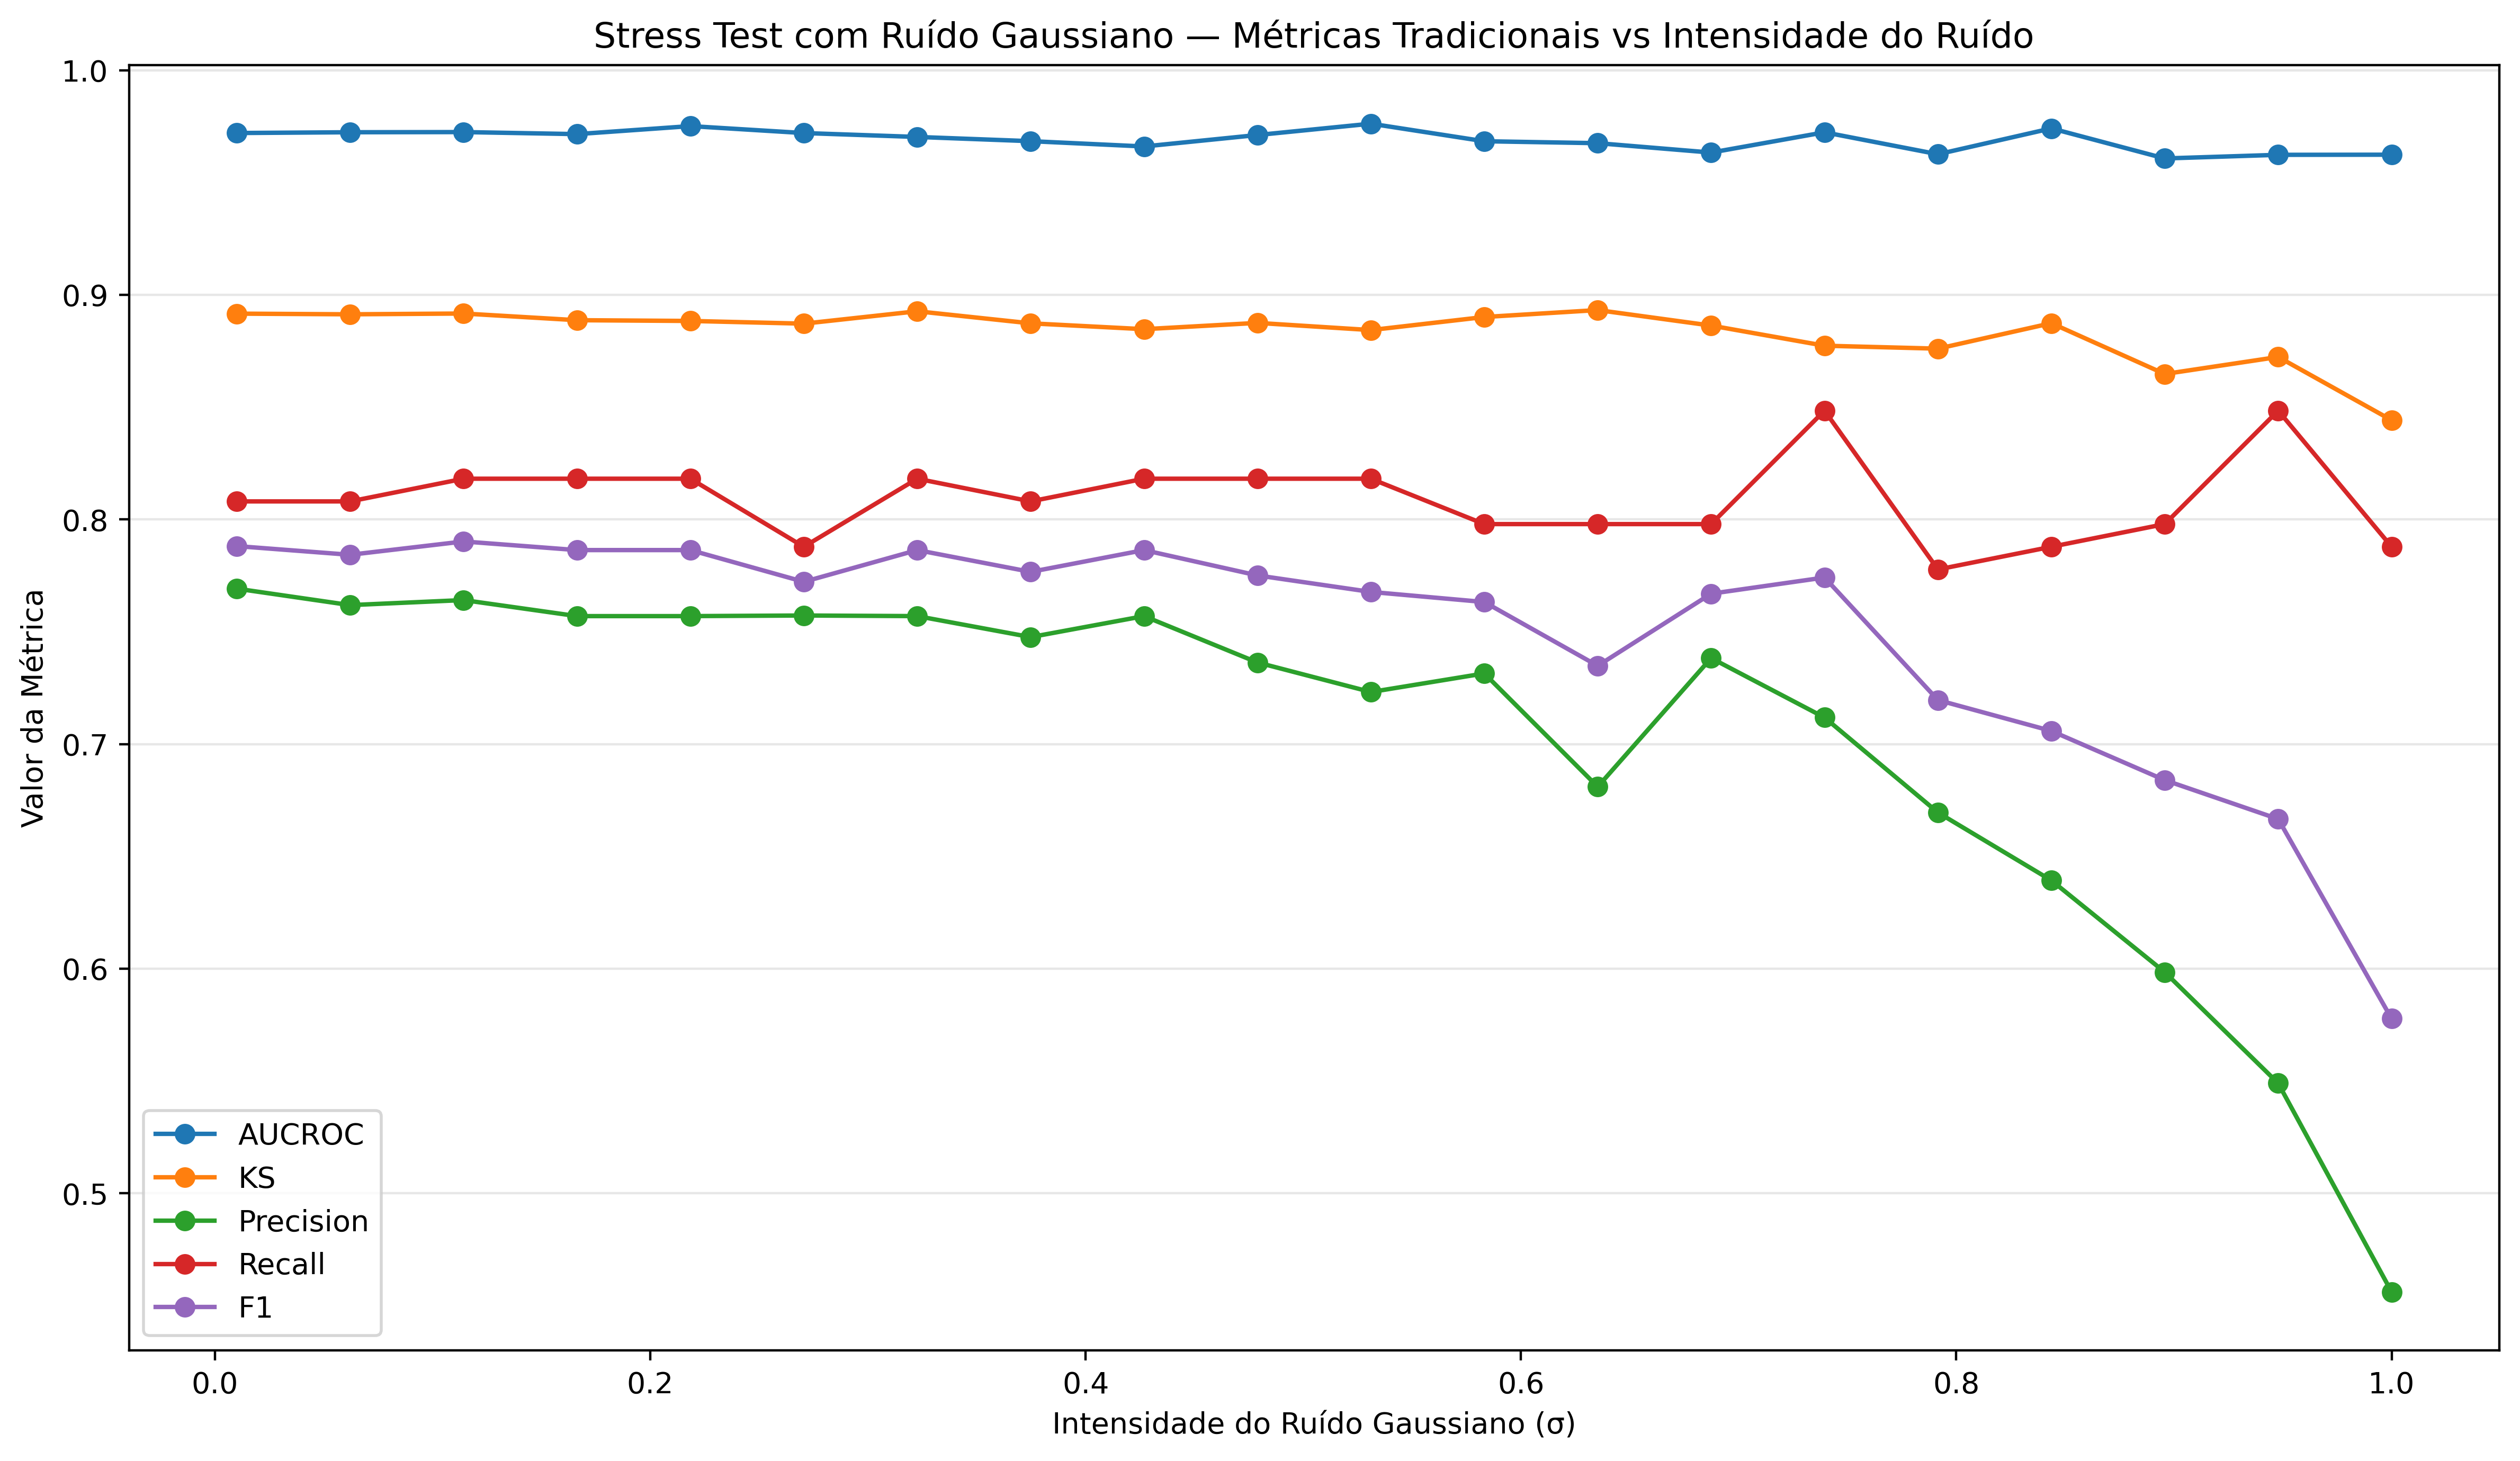

In [54]:
plt.figure(figsize=(12, 7))

for metric in ["AUCROC", "KS", "Precision", "Recall", "F1"]:
    plt.plot(
        stress_df["Sigma_ruido"],
        stress_df[metric],
        marker="o",
        label=metric
    )

plt.xlabel("Intensidade do Ruído Gaussiano (σ)")
plt.ylabel("Valor da Métrica")
plt.title("Stress Test com Ruído Gaussiano — Métricas Tradicionais vs Intensidade do Ruído")
plt.legend()
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

O stress testing com ruído gaussiano evidencia elevada robustez estatística do modelo de Regressão Logística. Observa-se que métricas associadas à capacidade de ordenação, como AUC-ROC e KS, permanecem praticamente inalteradas mesmo sob níveis elevados de ruído, indicando que o score gerado pelo modelo continua informativo em cenários adversos. Por outro lado, métricas dependentes do limiar de decisão, como precision e F1-score, apresentam degradação progressiva à medida que a intensidade do ruído aumenta, refletindo o aumento esperado de falsos positivos. O recall, por sua vez, mantém-se relativamente estável, evidenciando que a capacidade de captura de fraudes é preservada. Esses resultados indicam que a degradação observada está associada principalmente à política de decisão adotada, e não à perda de poder discriminativo do modelo, reforçando a robustez da abordagem e a possibilidade de ajustes operacionais do threshold em cenários de deterioração do ambiente.

### Stress Testing com deterioração do cenário econômico

O stress test econômico foi conduzido com o objetivo de avaliar a resiliência da política de decisão baseada no modelo, mantendo o classificador e o limiar ótimo completamente congelados e variando exclusivamente os parâmetros econômicos do ambiente operacional. Dessa forma, a análise isola o impacto da deterioração do cenário externo, sem confundir efeitos de reotimização ou ajuste oportunista do modelo. Esse tipo de stress test não avalia capacidade preditiva, mas sim resiliência econômica.

A pergunta central é: ***"Se o contexto econômico se deteriorar, quanto valor a política ainda consegue preservar?***

Antes das etapas, alguns pontos-chave (todos alinhados com boas práticas):
- Modelo congelado: Nenhum refit, nenhuma recalibração.
- Threshold congelado: O limiar ótimo continua sendo parte da política.
- Somente os custos e ganhos são alterados: A matriz de payoff muda, não as decisões.
- Cenários são contrafactuais: Simulam mudanças externas (fraude mais cara, FP mais penalizado), não erros do modelo.

Isso garante que não haja vazamento de informação e nem reotimização oportunista (viés de confirmação), além de que o impacto observado seja exclusivamente econômico.

As etapas da Análise são:
1) Definição da métrica de negócio parametrizada
2) Fixação das decisões observadas
3) Definição do cenário base (referência)
4) Introdução de degradação progressiva
5) Consolidação e comparação

Os seguintes cenários serão explorados:

- Cenário 0 — Base (Operação Normal);

- Cenário 1 — Pressão Moderada
  - aumento gradual do valor médio das fraudes;
  - ataques mais frequentes, porém ainda controláveis;
  - custos operacionais estáveis.

- Cenário 2 — Ambiente Adverso
  - fraudes mais caras;
  - maior complexidade de ataque;
  - clientes mais sensíveis a bloqueios.

- Cenário 3 — Crise Operacional
  - fraudes de alto impacto financeiro;
  - alto custo de rejeições indevidas;
  - risco reputacional e regulatório.

- Cenário 4 — Stress Extremo (Black Swan)
  - ataques coordenados;
  - tickets muito elevados;
  - custos operacionais severos;
  - ambiente fora do normal histórico.

In [55]:
# Definição da métrica de negócio parametrizada
def business_metric_stress(
    y_true,
    y_pred,
    amount,
    fn_multiplier=1.0,
    fp_cost=-5,
    tp_gain=50,
    tn_rate=0.02
):
    mask_tp = (y_true == 1) & (y_pred == 1)
    mask_tn = (y_true == 0) & (y_pred == 0)
    mask_fp = (y_true == 0) & (y_pred == 1)
    mask_fn = (y_true == 1) & (y_pred == 0)

    fraudulent_refuse = mask_tp.sum() * tp_gain
    fraudulent_accept = -(amount[mask_fn] * fn_multiplier).sum()
    legitimate_refuse = mask_fp.sum() * fp_cost
    legitimate_accept = (amount[mask_tn] * tn_rate).sum()

    return (
        fraudulent_refuse
        + fraudulent_accept
        + legitimate_refuse
        + legitimate_accept
    )


In [56]:
# Fixação das decisões observadas com base no limiar otimo
y_pred_test_opt = (y_proba_test >= best_threshold).astype(int)

In [57]:
# Definição dos cenários
results = []

# Cenário 0 — Base
results.append({
    "Cenário": "Base",
    "Benefício (€)": business_metric_stress(
        y_test, y_pred_test_opt, amount_test
    )
})

# Cenário 1 — Fraude +25%
results.append({
    "Cenário": "Fraude +25%",
    "Benefício (€)": business_metric_stress(
        y_test, y_pred_test_opt, amount_test,
        fn_multiplier=1.25
    )
})

# Cenário 2 — Fraude +50% + fp_cost=-10
results.append({
    "Cenário": "Adverso",
    "Benefício (€)": business_metric_stress(
        y_test, y_pred_test_opt, amount_test,
        fn_multiplier=1.50,
        fp_cost=-10
    )
})

# Cenário 3 — Hostil (Fraude +70% + FP mais caro)
results.append({
    "Cenário": "Crise Operacional",
    "Benefício (€)": business_metric_stress(
        y_test, y_pred_test_opt, amount_test,
        fn_multiplier=1.70,
        fp_cost=-15
    )
})

# Cenário 4 — Catastrófico (Fraude +80% + FP mais caro)
results.append({
    "Cenário": "Cisne Negro",
    "Benefício (€)": business_metric_stress(
        y_test, y_pred_test_opt, amount_test,
        fn_multiplier=2.0,
        fp_cost=-25
    )
})


In [58]:
stress_df = pd.DataFrame(results)
stress_df

Cenário  Benefício (€)
0               Base    101457.2686
1        Fraude +25%    100816.4986
2            Adverso    100055.7286
3  Crise Operacional     99423.1126
4        Cisne Negro     98414.1886

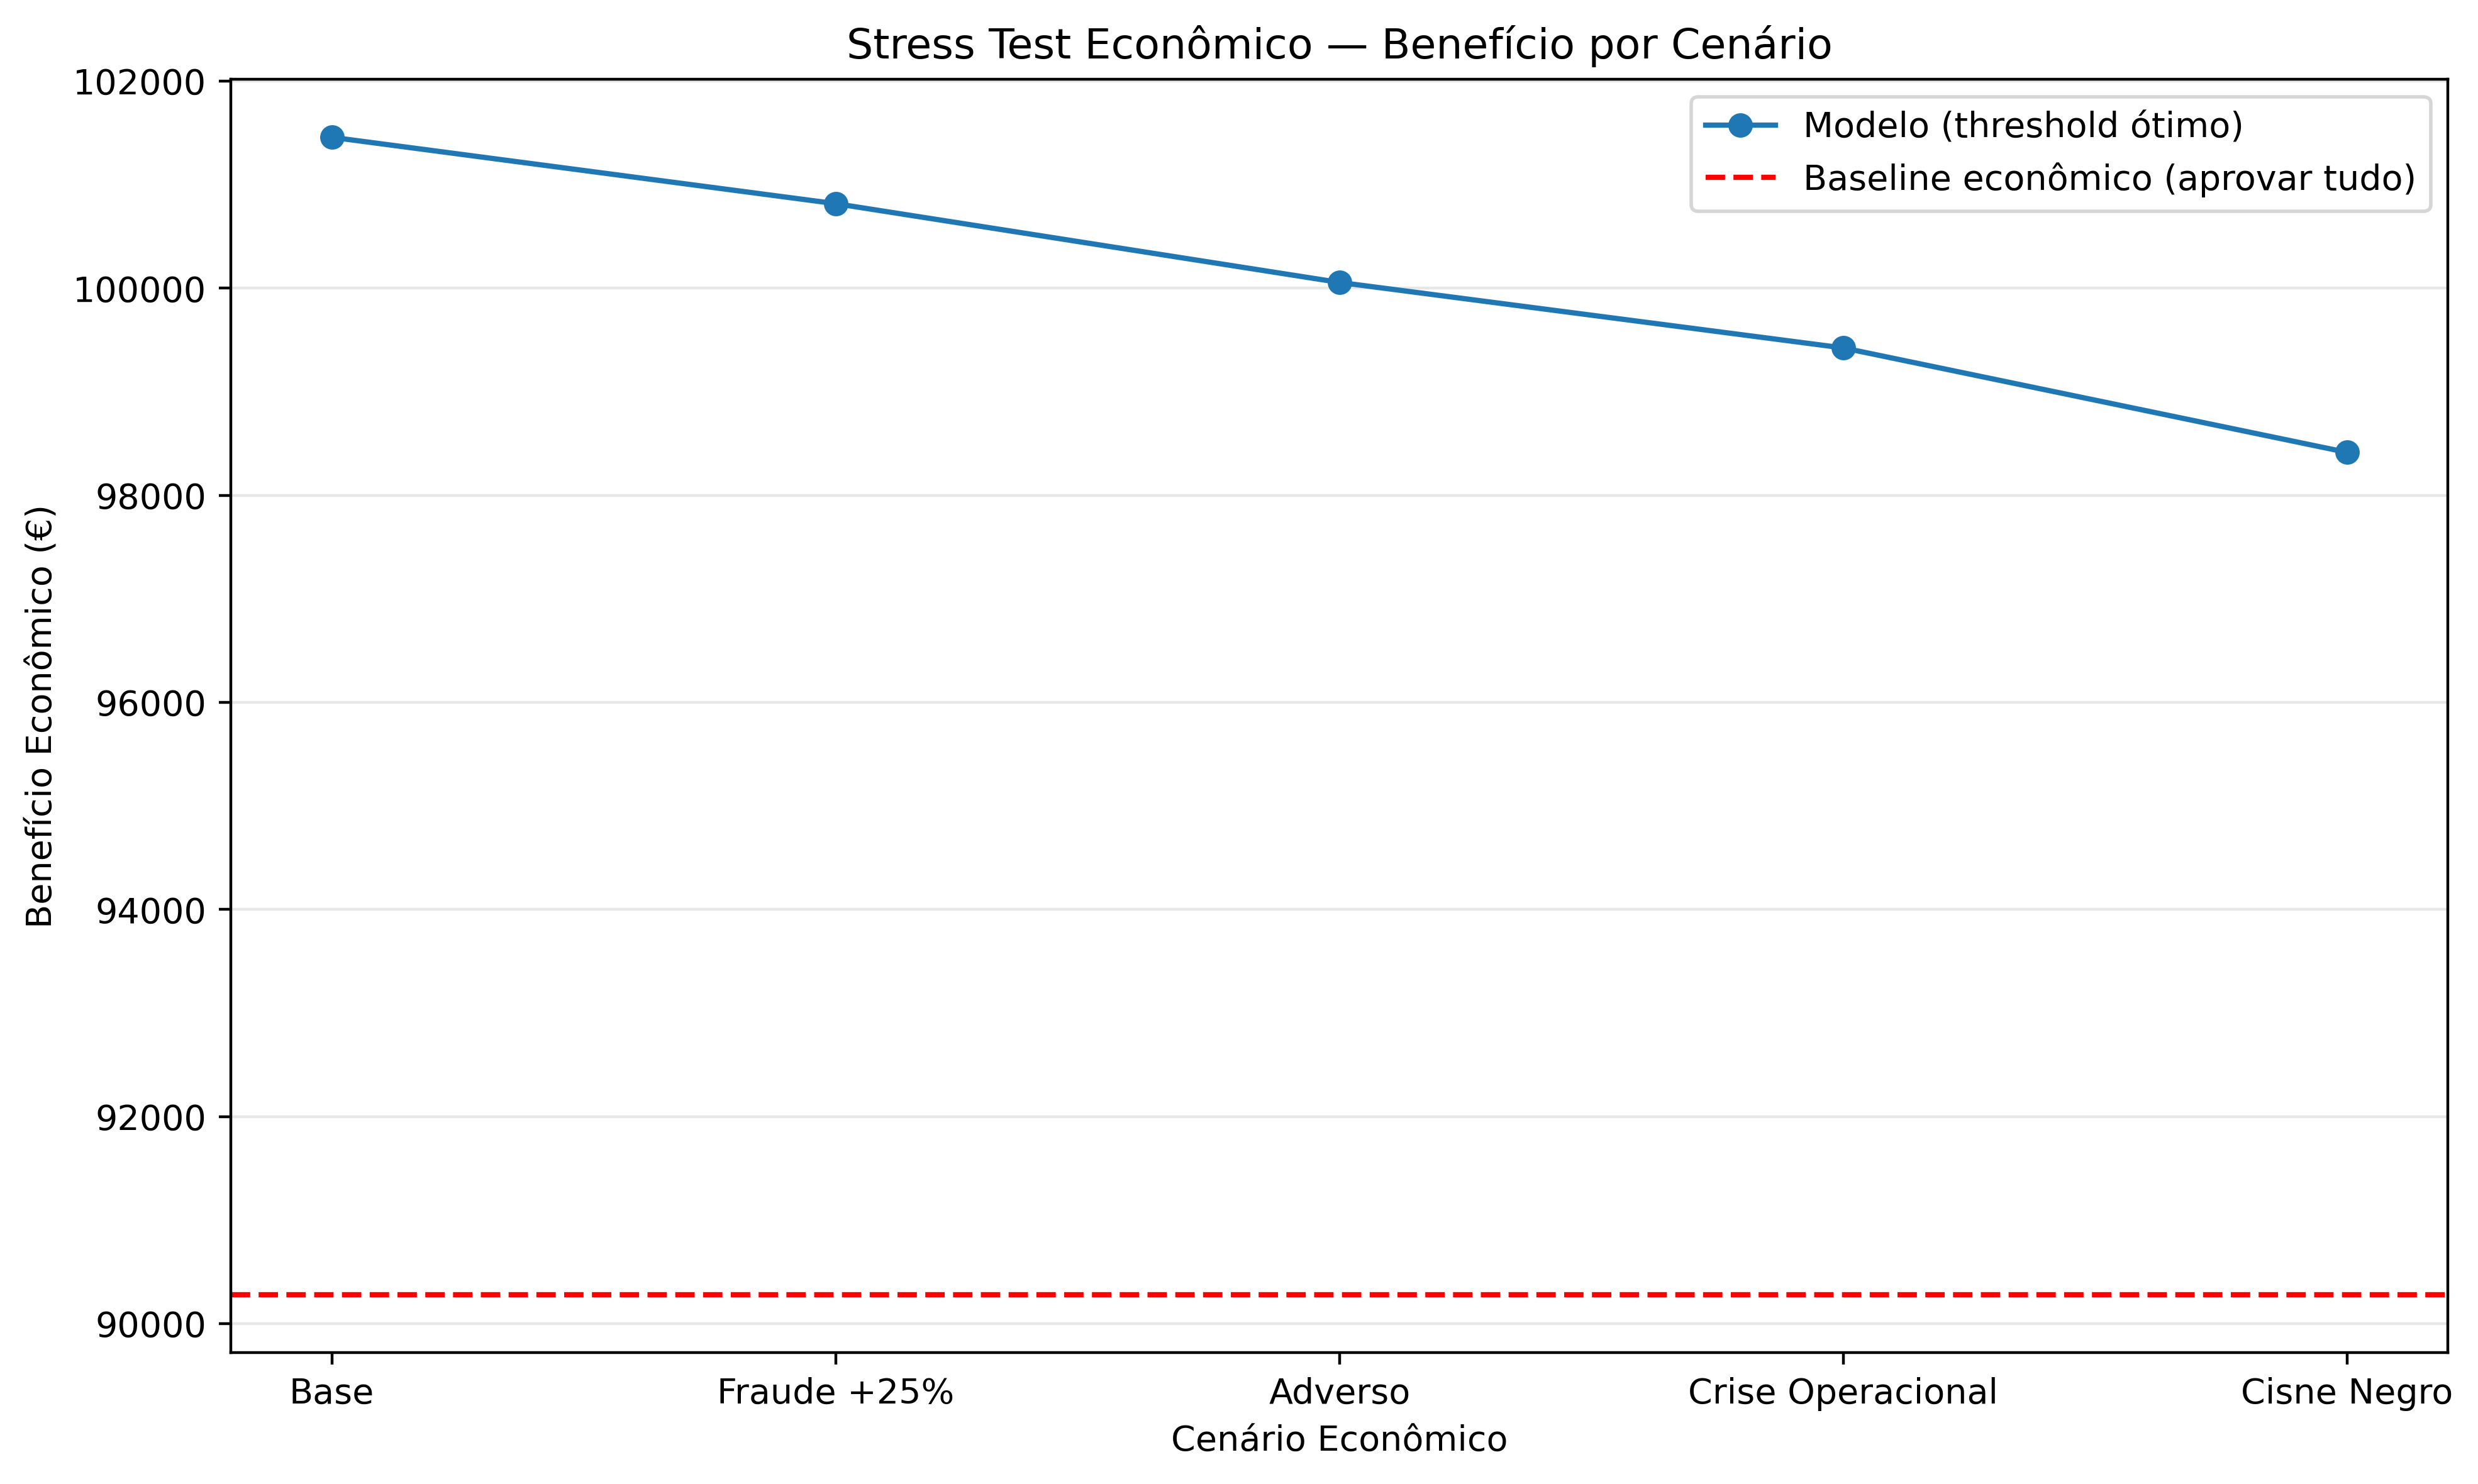

In [59]:
baseline_value = 90280.45

plt.figure(figsize=(10, 6))

# Linha do modelo sob diferentes cenários
plt.plot(
    stress_df["Cenário"],
    stress_df["Benefício (€)"],
    marker="o",
    label="Modelo (threshold ótimo)"
)

# Linha horizontal do baseline
plt.axhline(
    y=baseline_value,
    linestyle="--",
    color="red",
    label="Baseline econômico (aprovar tudo)"
)

plt.xlabel("Cenário Econômico")
plt.ylabel("Benefício Econômico (€)")
plt.title("Stress Test Econômico — Benefício por Cenário")
plt.legend()
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


Os resultados mostram que, mesmo sob condições progressivamente mais adversas, o modelo mantém desempenho econômico consistentemente superior ao baseline econômico representado pela política de aprovar todas as transações. No cenário base, o benefício econômico do modelo já supera o baseline de forma significativa. À medida que o ambiente se deteriora — com aumento da severidade das fraudes e maior custo associado a decisões incorretas — observa-se uma redução gradual do benefício econômico, porém sem reversão do ganho em nenhum dos cenários avaliados.

Mesmo no cenário mais extremo (cisne negro), caracterizado por um aumento severo no impacto financeiro das fraudes e custos operacionais elevados, a política baseada no modelo permanece acima do baseline econômico. Esse comportamento indica que o modelo não apenas gera valor em condições normais, mas também atua como mecanismo de mitigação de risco, amortecendo perdas em ambientes hostis.

A inclinação relativamente suave da curva de benefício ao longo dos cenários sugere que a política de decisão possui uma margem de segurança econômica relevante, operando de forma estável antes de qualquer ponto de ruptura. Em termos práticos, isso significa que a adoção do modelo não depende de um cenário excessivamente favorável para ser vantajosa, o que fortalece sua viabilidade operacional e estratégica.

Em síntese, o stress test evidencia que o ganho econômico proporcionado pelo modelo é robusto a choques adversos, reforçando que o valor extraído não decorre de um ajuste frágil ao cenário atual, mas sim de uma política de decisão estruturalmente superior ao baseline. Esse resultado posiciona o modelo não apenas como uma ferramenta de otimização, mas como um componente relevante de gestão de risco econômico em sistemas de detecção de fraude.

# Feature Engineering

Hipótese:
Transações com `amount = 0` apresentam um risco de fraude significativamente diferente das demais transações e, portanto, a criação de uma flag binária pode aumentar o poder preditivo e/ou o ganho econômico do modelo.

In [60]:
X_train_f = X_train.copy()
X_val_f   = X_val.copy()
X_test_f  = X_test.copy()

for X_split in [X_train_f, X_val_f, X_test_f]:
    X_split["flag_amount_zero"] = (X_split["Amount"] == 0).astype(int)


In [61]:
features_base = X_train_f.columns.drop("flag_amount_zero")
features_flag = X_train_f.columns

In [62]:
from sklearn.base import clone

# Modelo âncora
logit_anchor.fit(X_train_f[features_base], y_train)

# Modelo âncora + flag
logit_flag = clone(logit_anchor)
logit_flag.fit(X_train_f[features_flag], y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('amount_scaler',
                                                  StandardScaler(),
                                                  ['Amount']),
                                                 ('passthrough', 'passthrough',
                                                  ['V1', 'V2', 'V3', 'V4', 'V5',
                                                   'V6', 'V7', 'V8', 'V9',
                                                   'V10', 'V11', 'V12', 'V13',
                                                   'V14', 'V15', 'V16', 'V17',
                                                   'V18', 'V19', 'V20', 'V21',
                                                   'V22', 'V23', 'V24', 'V25',
                                                   'V26', 'V27', 'V28'])])),
                ('clf', LogisticRegression(max_iter=1000, random_state=42))])

In [63]:
# probabilidades na validação
y_proba_anchor_val = logit_anchor.predict_proba(
    X_val_f[features_base]
)[:, 1]

y_proba_flag_val = logit_flag.predict_proba(
    X_val_f[features_flag]
)[:, 1]


In [64]:
# threshold congelado
thr = best_threshold

y_pred_anchor_val = (y_proba_anchor_val >= thr).astype(int)
y_pred_flag_val   = (y_proba_flag_val   >= thr).astype(int)


In [65]:
# métrica de negócio
ganho_anchor = business_metric(
    y_val, y_pred_anchor_val, amount_val
)

ganho_flag = business_metric(
    y_val, y_pred_flag_val, amount_val
)

ganho_anchor, ganho_flag, ganho_flag - ganho_anchor


(np.float64(99150.8962), np.float64(99150.8962), np.float64(0.0))

Conforme antecipado na análise exploratória, a baixa representatividade das transações de valor zero limitou o impacto operacional da feature. A feature `flag_amount_zero` não apresentou ganho econômico incremental quando avaliada na base de validação, sob o threshold previamente otimizado. Ambos os cenários — modelo âncora e modelo com a nova feature — resultaram em ganho nulo, indicando que o sinal identificado não se traduz em benefício financeiro no regime atual de decisão. Dessa forma, a feature foi descartada para o modelo final.

# Estratégias de Balanceamento do Dataset

In [66]:
balance_strategies = {
    "Baseline_Desbalanceado": None,

    "ClassWeight_Balanced": {
        "class_weight": "balanced"
    },

    "Random_OverSampling": RandomOverSampler(
        sampling_strategy=0.5,
        random_state=42
    ),

    "SMOTE": SMOTE(
        sampling_strategy=0.5,
        random_state=42
    ),

    "Random_UnderSampling": RandomUnderSampler(
        sampling_strategy=0.5,
        random_state=42
    ),

    "Tomek_Links": TomekLinks(),

    "SMOTE_Tomek": SMOTETomek(
        sampling_strategy=0.5,
        random_state=42
    )
}


In [67]:
# defindo dicionarios para o armazenamento dos resultados
balance_results = []
balance_desempenho = {}

In [68]:
threshold_grid = np.linspace(0.01, 0.99, 99)

for nome, strategy in balance_strategies.items():

    print(f"\nTestando estratégia: {nome}")

    # --------------------------------------------------
    # Construção do pipeline
    # --------------------------------------------------
    if strategy is None:
        pipe = Pipeline([
            ("preprocess", preprocessor),
            ("clf", LogisticRegression(
                max_iter=1000,
                solver="lbfgs",
                random_state=42
            ))
        ])

    elif isinstance(strategy, dict):  # class_weight
        pipe = Pipeline([
            ("preprocess", preprocessor),
            ("clf", LogisticRegression(
                max_iter=1000,
                solver="lbfgs",
                class_weight=strategy["class_weight"],
                random_state=42
            ))
        ])

    else:  # estratégias com resampling
        pipe = ImbPipeline([
            ("preprocess", preprocessor),
            ("sampler", strategy),
            ("clf", LogisticRegression(
                max_iter=1000,
                solver="lbfgs",
                random_state=42
            ))
        ])

    # --------------------------------------------------
    # Fit no conjunto de treino
    # --------------------------------------------------
    pipe.fit(X_train, y_train)

    # --------------------------------------------------
    # Otimização do threshold — VALIDAÇÃO
    # --------------------------------------------------
    y_proba_val = pipe.predict_proba(X_val)[:, 1]

    business_values = []
    for thr in threshold_grid:
        y_pred_val = (y_proba_val >= thr).astype(int)
        business_values.append(
            business_metric(y_val, y_pred_val, amount_val)
        )

    business_values = np.array(business_values)
    best_idx = np.argmax(business_values)
    best_threshold_strategy = threshold_grid[best_idx]

    # --------------------------------------------------
    # Avaliação no TESTE
    # --------------------------------------------------
    y_proba_test = pipe.predict_proba(X_test)[:, 1]
    y_pred_test = (y_proba_test >= best_threshold_strategy).astype(int)

    business_test = business_metric(
        y_test,
        y_pred_test,
        amount_test
    )

    # --------------------------------------------------
    # Métricas tradicionais
    # --------------------------------------------------
    desempenho = af.calcula_desempenho(
        pipe,
        X_train, y_train,
        X_test, y_test,
        best_threshold_strategy
    )

    balance_desempenho[nome] = desempenho

    # --------------------------------------------------
    # Armazenar resultados
    # --------------------------------------------------
    balance_results.append({
        "Estratégia": nome,
        "Threshold_Ótimo": best_threshold_strategy,
        "Business_Val (€)": business_values[best_idx],
        "Business_Test (€)": business_test
    })


Testando estratégia: Baseline_Desbalanceado

Testando estratégia: ClassWeight_Balanced

Testando estratégia: Random_OverSampling

Testando estratégia: SMOTE


Exception in thread Thread-5 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\jooar\miniconda3\envs\fraud-transactions-detection\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "c:\Users\jooar\miniconda3\envs\fraud-transactions-detection\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\jooar\miniconda3\envs\fraud-transactions-detection\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc6 in position 80: invalid continuation byte



Testando estratégia: Random_UnderSampling

Testando estratégia: Tomek_Links

Testando estratégia: SMOTE_Tomek


In [69]:
df_balance_business = pd.DataFrame(balance_results)
df_balance_business

Estratégia  Threshold_Ótimo  Business_Val (€)  \
0  Baseline_Desbalanceado             0.09        99150.8962   
1    ClassWeight_Balanced             0.99        99499.0560   
2     Random_OverSampling             0.99        99578.1228   
3                   SMOTE             0.99        99609.2828   
4    Random_UnderSampling             0.99        98876.1418   
5             Tomek_Links             0.02        99096.6362   
6             SMOTE_Tomek             0.99        99609.2828   

   Business_Test (€)  
0        101457.2686  
1        100791.8962  
2        101152.5130  
3        101619.5144  
4        100789.1722  
5        101397.4796  
6        101619.5144

In [70]:
df_bal_desemp = (
    pd.concat(balance_desempenho, axis=0)
      .reset_index()
      .rename(columns={"level_0":"estratégia", "level_1": "métrica"})
)

df_bal_desemp

estratégia    métrica    Treino     Teste  Variação
0   Baseline_Desbalanceado   Acurácia  0.999333  0.999245     -0.00
1   Baseline_Desbalanceado     AUCROC  0.983235  0.972161     -0.01
2   Baseline_Desbalanceado         KS  0.892885  0.891727     -0.00
3   Baseline_Desbalanceado  Precision  0.806780  0.769231     -0.05
4   Baseline_Desbalanceado     Recall  0.806780  0.808081      0.00
5   Baseline_Desbalanceado         F1  0.806780  0.788177     -0.02
6     ClassWeight_Balanced   Acurácia  0.999034  0.998859     -0.00
7     ClassWeight_Balanced     AUCROC  0.990180  0.967941     -0.02
8     ClassWeight_Balanced         KS  0.912174  0.900878     -0.01
9     ClassWeight_Balanced  Precision  0.680556  0.628788     -0.08
10    ClassWeight_Balanced     Recall  0.830508  0.838384      0.01
11    ClassWeight_Balanced         F1  0.748092  0.718615     -0.04
12     Random_OverSampling   Acurácia  0.999216  0.999087     -0.00
13     Random_OverSampling     AUCROC  0.989703  0.969141     -0.02
14     Random_OverSampling         KS  0.909564  0.902408     -0.01
15     Random_OverSampling  Precision  0.747692  0.697479     -0.07
16     Random_OverSampling     Recall  0.823729  0.838384      0.02
17     Random_OverSampling         F1  0.783871  0.761468     -0.03
18                   SMOTE   Acurácia  0.999257  0.999192     -0.00
19                   SMOTE     AUCROC  0.988269  0.967279     -0.02
20                   SMOTE         KS  0.921604  0.897537     -0.03
21                   SMOTE  Precision  0.760870  0.734513     -0.03
22                   SMOTE     Recall  0.830508  0.838384      0.01
23                   SMOTE         F1  0.794165  0.783019     -0.01
24    Random_UnderSampling   Acurácia  0.997694  0.997384     -0.00
25    Random_UnderSampling     AUCROC  0.987772  0.968408     -0.02
26    Random_UnderSampling         KS  0.906462  0.891199     -0.02
27    Random_UnderSampling  Precision  0.417910  0.386364     -0.08
28    Random_UnderSampling     Recall  0.854237  0.858586      0.01
29    Random_UnderSampling         F1  0.561247  0.532915     -0.05
30             Tomek_Links   Acurácia  0.998765  0.998683     -0.00
31             Tomek_Links     AUCROC  0.981515  0.973814     -0.01
32             Tomek_Links         KS  0.894620  0.889500     -0.01
33             Tomek_Links  Precision  0.599526  0.582192     -0.03
34             Tomek_Links     Recall  0.857627  0.858586      0.00
35             Tomek_Links         F1  0.705718  0.693878     -0.02
36             SMOTE_Tomek   Acurácia  0.999257  0.999192     -0.00
37             SMOTE_Tomek     AUCROC  0.988269  0.967279     -0.02
38             SMOTE_Tomek         KS  0.921604  0.897537     -0.03
39             SMOTE_Tomek  Precision  0.760870  0.734513     -0.03
40             SMOTE_Tomek     Recall  0.830508  0.838384      0.01
41             SMOTE_Tomek         F1  0.794165  0.783019     -0.01

In [71]:
# Transformando os DataFrames
# Treino
bal_treino = pd.pivot(
    data=df_bal_desemp,
    index="estratégia",
    columns='métrica',
    values='Treino'
)

bal_treino.rename(columns={
    'AUCROC': 'AUCROC_Treino',
    'Acurácia': 'Acurácia_Treino',
    'F1':'F1_Treino',
    'KS':'KS_Treino',
    'Precision':'Precision_Treino',
    'Recall':'Recall_Treino'
}, inplace= True)

# Teste
bal_teste = pd.pivot(
    data=df_bal_desemp,
    index="estratégia",
    columns='métrica',
    values='Teste'
)

bal_teste.rename(columns={
    'AUCROC': 'AUCROC_Teste',
    'Acurácia': 'Acurácia_Teste',
    'F1': 'F1_Teste',
    'KS': 'KS_Teste',
    'Precision': 'Precision_Teste',
    'Recall': 'Recall_Teste'
}, inplace=True)

# Variação
bal_variacao = pd.pivot(
    data=df_bal_desemp,
    index="estratégia",
    columns='métrica',
    values='Variação'
)

bal_variacao.rename(columns={
    'AUCROC': 'AUCROC_Variacao',
    'Acurácia': 'Acurácia_Variacao',
    'F1': 'F1_Variacao',
    'KS': 'KS_Variacao',
    'Precision': 'Precision_Variacao',
    'Recall': 'Recall_Variacao'
}, inplace=True)


In [72]:
busca_bal = pd.concat([bal_treino, bal_teste, bal_variacao], axis=1)
busca_bal.reset_index(inplace=True)
busca_bal

métrica              estratégia  AUCROC_Treino  Acurácia_Treino  F1_Treino  \
0        Baseline_Desbalanceado       0.983235         0.999333   0.806780   
1          ClassWeight_Balanced       0.990180         0.999034   0.748092   
2           Random_OverSampling       0.989703         0.999216   0.783871   
3          Random_UnderSampling       0.987772         0.997694   0.561247   
4                         SMOTE       0.988269         0.999257   0.794165   
5                   SMOTE_Tomek       0.988269         0.999257   0.794165   
6                   Tomek_Links       0.981515         0.998765   0.705718   

métrica  KS_Treino  Precision_Treino  Recall_Treino  AUCROC_Teste  \
0         0.892885          0.806780       0.806780      0.972161   
1         0.912174          0.680556       0.830508      0.967941   
2         0.909564          0.747692       0.823729      0.969141   
3         0.906462          0.417910       0.854237      0.968408   
4         0.921604          0.760870       0.830508      0.967279   
5         0.921604          0.760870       0.830508      0.967279   
6         0.894620          0.599526       0.857627      0.973814   

métrica  Acurácia_Teste  F1_Teste  KS_Teste  Precision_Teste  Recall_Teste  \
0              0.999245  0.788177  0.891727         0.769231      0.808081   
1              0.998859  0.718615  0.900878         0.628788      0.838384   
2              0.999087  0.761468  0.902408         0.697479      0.838384   
3              0.997384  0.532915  0.891199         0.386364      0.858586   
4              0.999192  0.783019  0.897537         0.734513      0.838384   
5              0.999192  0.783019  0.897537         0.734513      0.838384   
6              0.998683  0.693878  0.889500         0.582192      0.858586   

métrica  AUCROC_Variacao  Acurácia_Variacao  F1_Variacao  KS_Variacao  \
0                  -0.01               -0.0        -0.02        -0.00   
1                  -0.02               -0.0        -0.04        -0.01   
2                  -0.02               -0.0        -0.03        -0.01   
3                  -0.02               -0.0        -0.05        -0.02   
4                  -0.02               -0.0        -0.01        -0.03   
5                  -0.02               -0.0        -0.01        -0.03   
6                  -0.01               -0.0        -0.02        -0.01   

métrica  Precision_Variacao  Recall_Variacao  
0                     -0.05             0.00  
1                     -0.08             0.01  
2                     -0.07             0.02  
3                     -0.08             0.01  
4                     -0.03             0.01  
5                     -0.03             0.01  
6                     -0.03             0.00

In [73]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: #90ee90' if v else '' for v in is_max]

bal_test = bal_teste.style.apply(highlight_max, axis=0)\
                         .set_caption("Desempenho dos Modelos no Teste – Destaque para os Melhores")
bal_test

In [74]:
def highlight_min_abs(s):
    abs_vals = s.abs()                 # calcula valor absoluto
    min_abs = abs_vals.min()           # menor valor absoluto da coluna
    return ['background-color: #add8e6' if abs(v) == min_abs else '' for v in s]


bal_var = bal_variacao.style.apply(highlight_min_abs, axis=0)\
                         .set_caption("Variação entre Treino e Teste – Destaque para os Melhores")

bal_var

Em problemas de detecção de fraudes, é intuitivo assumir que o objetivo ideal do modelo seja identificar o maior número possível de transações fraudulentas. De fato, sob uma perspectiva puramente classificatória, métricas como recall e F1-score favorecem modelos que maximizam a captura da classe positiva. No entanto, em cenários reais sensíveis a custo, essa abordagem ignora um aspecto fundamental: fraudes possuem impactos financeiros heterogêneos.

No contexto analisado, o custo de uma fraude aceita é proporcional ao valor da transação, enquanto o custo de uma transação legítima bloqueada é fixo e representa não apenas uma perda financeira direta, mas também atrito com o cliente e potencial impacto reputacional. Dessa forma, a captura de fraudes adicionais de baixo valor pode não compensar o aumento no número de falsos positivos necessário para alcançá-las.

Os experimentos conduzidos demonstraram que estratégias de balanceamento, embora eficazes para aumentar o recall e melhorar métricas tradicionais, induzem uma redistribuição das probabilidades preditas que exige políticas de decisão extremamente conservadoras. Como consequência, o limiar ótimo desloca-se para valores elevados, neutralizando parte do ganho de recall e limitando o impacto econômico marginal.

Esses resultados evidenciam que, em um problema orientado a valor econômico, o objetivo ótimo não é maximizar a quantidade de fraudes detectadas, mas maximizar o impacto financeiro mitigado, priorizando transações fraudulentas de maior valor. Assim, a política de decisão torna-se um elemento tão relevante quanto o próprio modelo preditivo, e a otimização explícita do limiar de decisão baseada em custo mostra-se mais eficaz do que técnicas de balanceamento voltadas exclusivamente à melhoria de métricas estatísticas.

# Exportando

## Modelo Âncora

In [75]:
ANCHOR_ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

In [76]:
# salvando o modelo âncora final
joblib.dump(
    logit_anchor,
    ANCHOR_ARTIFACTS_DIR / "logit_anchor.joblib"
)

# salvando o threshold ótimo final
threshold_info = {
    "optimal_threshold": float(best_threshold),
    "business_metric": float(business_test_opt),
    "strategy": "maximize_business_metric",
    "split": "validation"
}

with open(ANCHOR_ARTIFACTS_DIR / "threshold.json", "w") as f:
    json.dump(threshold_info, f, indent=4)


## Splits

In [77]:

SPLITS_DIR.mkdir(parents=True, exist_ok=True)

In [78]:
def save_split(X, y, amount, name):
    df = X.copy()

    df["target"] = y.astype("int8")
    df["amount"] = amount.astype("float32")

    df.to_parquet(
        SPLITS_DIR / f"{name}.parquet",
        index=True
    )

In [79]:
save_split(X_train, y_train, amount_train, "train")
save_split(X_val, y_val, amount_val, "val")
save_split(X_test, y_test, amount_test, "test")

print("Splits saved successfully:")
for p in SPLITS_DIR.iterdir():
    print("-", p.name)

Splits saved successfully:
- metadata.json
- test.parquet
- train.parquet
- val.parquet


## Configurações da Métrica de Negócio

In [80]:
METRIC_ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

In [81]:
# Salvando a configuração da métrica de negócio
metric_config = {
    "metric_name": "business_metric",
    "version": "v1",
    "gain_legitimate_accept_rate": 0.02,
    "gain_fraud_refuse": 50,
    "loss_legitimate_refuse": 5,
    "description": "Business-driven metric for fraud detection",
    "used_for": ["threshold_optimization", "model_comparison"]
}

with open(METRIC_ARTIFACTS_DIR / "business_metric_config.json", "w") as f:
    json.dump(metric_config, f, indent=4)

# Considerações Finais

Embora pareça intuitivo buscar um sistema que identifique todas as fraudes, na prática cada decisão envolve um custo. Bloquear uma transação legítima gera prejuízo financeiro e insatisfação do cliente, enquanto nem toda fraude possui o mesmo impacto econômico. Os resultados mostram que o modelo já consegue capturar a maior parte das fraudes de alto valor, responsáveis pelo maior prejuízo financeiro. As tentativas de capturar fraudes adicionais, em sua maioria de baixo valor, exigem bloquear muito mais transações legítimas, o que reduz o ganho líquido do sistema. Dessa forma, o modelo adotado não busca apenas identificar mais fraudes, mas sim maximizar o valor econômico total protegido, equilibrando prevenção de perdas e experiência do cliente.

Esses achados reforçam a importância de alinhar a avaliação de modelos preditivos aos objetivos reais do sistema, destacando que melhorias em métricas tradicionais de classificação não garantem, por si só, maior valor econômico. Em aplicações práticas, a política de decisão e a definição adequada da função de custo são tão relevantes quanto a escolha do algoritmo de aprendizado, e devem ser tratadas como componentes centrais do processo de modelagem.

# Próximos Passos

- Desenvolver um modelo tree-based para benchmark de perfomance;
- Testar algoritmos não supervisionados para detecção de anomalias como o IsolationForest.